In [1]:
import numpy as np
from numpy import genfromtxt
import pandas as pd
import seaborn as sns
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
from pylab import *
import networkx as nx
import scipy
from scipy.stats import linregress,lognorm,rv_continuous,powerlaw,invgamma,ks_2samp,expon,lognorm,pareto,weibull_min,fisk,poisson
import random
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cobra
from scipy.integrate import odeint

%matplotlib inline

# Thermodynamics Constrains Information Flow in Metabolic Networks

In this notebook, the relationship between metabolic thermodynamics and information flow is explored via application of linear noise analysis (LNA). It yields the figures in the corresponding manuscript and more. It is organized as follows:

### A. Application of LNA to a toy model of a metabolic reaction
The enzyme-catalyzed, reversible conversion of substrate, $S$, to product, $P$, is considered with varied thermodynamic parameter, $K_{eq}$. LNA is applied to an exhaustive range of steady-states to determine the mutual information between $S$ and $P$, $I(S;P)$, as a function of the affinity, $\mathcal{A}$, of the reaction.

### B. Expansion of the LNA framework to include regulatory interactions
The system is augmented to include a regulatory interaction in which $S$ also binds reversibly to a regulated protein, $E_R$, and the LNA framework is expanded to capture this interaction. Parameters are varied to show that the mutual information between $S$ and $E_R$, $I(S;E)$, is high for reactions operating far from equilibrium, where $I(S;P)$ is low.

### C. Analysis of pre-existing -omics data
Publicly-available mult-omics data are used to examine the relationship between real thermodynamic parameters and the presence of regulators. The hypothesis that substrates of reactions with small $K_{eq}$ are good regulators, as predicted by our model, is tested. 

## A. Application of LNA to a toy model of a metabolic reaction

Application of LNA involves solving the fluctuation-dissipation balance:

\begin{equation}
    \mathbf{AC} + \mathbf{CA^T} + \Omega \mathbf{BB^T} = \mathbf{0}
\end{equation}

For a system described by the vector equation:

\begin{equation}
    \mathbf{\dot{x}} = \mathbf{S} \cdot \mathbf{f}(\mathbf{x})
\end{equation}

where where $\mathbf{S}$ is the stoichiometric matrix, $\mathbf{f(x)}$ is the vector of rate equations, $\mathbf{A}$ is the Jacobian matrix evaluated at a given steady-state, $\mathbf{\bar{x}}$, and $\Omega$ is the system size. $\mathbf{BB^T}$ is the drift matrix, given by:

\begin{equation}
    \mathbf{BB^T} = \mathbf{S} \cdot diag(\mathbf{f}(\mathbf{\bar{x}})) \cdot \mathbf{S^T}
\end{equation}

where $diag(\mathbf{f}(\mathbf{\bar{x}}))$ is the matrix with diagonal elements equal to the entries of $\mathbf{f}(\mathbf{x})$ evaluated at $\mathbf{\bar{x}}$ and zero for all other elements.

The goal is to find $\mathbf{C}$ for various parameter values. As written, the fluctuation-dissipation balance is not easy to solve numberically for $\mathbf{C}$, so it is reformulated as:

\begin{equation}
    \mathbf{A'}\cdot \mathbf{C'} = -\Omega \mathbf{BB^{T'}}
\end{equation}

where $\mathbf{C'} = [C_{SS} \,\, C_{SP} \, \ldots \, C_{PP} \, \ldots \, C_{E^*E^*}]^T$ and $\mathbf{BB^{T'}} = [BB^T_{11} \,\, BB^T_{12} \, \ldots \, BB^T_{22} \, \ldots \, BB^T_{33}]^T$, i.e., vectors with entries corresponding to the serial entries of $\mathbf{C}$ and $\mathbf{BB^T}$. In this recasting, $\mathbf{A'}$ is a matrix with values derived from linear combinations of the entries of $\mathbf{A}$. Please see the supplemental material for more details.

In the following cells, the system and functions for determining the relevant matrices for solving the fluctuation-dissipation balance are explicitly defined based on the kinetics of the system.

### A.1 System definition
For the reversible, enzyme-catalyzed conversion of $S$ to $P$ with constant influx, $u$, there are two relevant mass balances:

\begin{equation}
    \frac{dS}{dt} = u - k^+E \frac{S/K_S}{1+S/K_S+P/K_P}\left(1-\frac{P/S}{K_{eq}}\right)
\end{equation}

\begin{equation}
    \frac{dP}{dt} = k^+E \frac{S/K_S}{1+S/K_S+P/K_P}\left(1-\frac{P/S}{K_{eq}}\right) - k_0P
\end{equation}

With

\begin{equation}
    K_{eq} = \frac{k^+/K_S}{k^-/K_P}
\end{equation}

and $k^+$ and $k^-$ being the turnover constants for the forward and reverse reactions, respectively, and $K_S$ and $K_P$ being the saturation constants for $S$ and $P$, respectively.

Nondimensionalization by defining $\tilde{S} = S/K_S$, $\tilde{P} = P/K_P$, and $\tilde{u} = u/(k^+E)$ yields:

\begin{equation}
    \frac{1}{k^+E}\frac{d\tilde{S}}{dt} = \tilde{u} - \frac{\tilde{S}}{1+\tilde{S}+\tilde{P}}\left(1-\frac{\tilde{P}}{\tilde{S}}\frac{k^-}{k^+}\right)
\end{equation}

\begin{equation}
    \frac{1}{k^+E}\frac{dP}{dt} = \frac{\tilde{S}}{1+\tilde{S}+\tilde{P}}\left(1-\frac{\tilde{P}}{\tilde{S}}\frac{k^-}{k^+}\right) - k_0'P
\end{equation}

Two parameters remain following nondimensionalization: $\frac{k^-}{k^+} \equiv K \propto K_{eq}^{-1}$, and $k_0' \equiv k$.

This system has a single steady state, $(\bar{S}, \bar{P})$, for a given flux $\tilde{u} \in [0,1)$:

\begin{equation}
    \bar{S} = \frac{\tilde{u}}{1-\tilde{u}}\left[1-\frac{\tilde{u}}{k}\left(\tilde{u}-K\right)\right]
\end{equation}

\begin{equation}
    \bar{P} = \frac{\tilde{u}}{k}
\end{equation}

Since flux balance must be maintained, it is possible determine every possible steady state by simply varying $\tilde{u}$ from 0 to 1. Similarly, the flux balance constraint yields a drift matrix, $\mathbf{BB^T}$, which depends only on the flux through the reaction:

\begin{equation}
\mathbf{BB^T} = \begin{bmatrix}
2\tilde{u} & -\tilde{u}\\
-\tilde{u} & 2\tilde{u}
\end{bmatrix}
\end{equation}

See the paper and Supplemental Information for an explanation of other LNA-associated matrices for this system.

### A.2 System Analysis Using LNA

In the following cells, LNA is used to analyze the system defined above. 

In [3]:
# Defines a function which determines steady state based on flux u and two parameters K and k, then determines and returns
# the affinity and the covariance vector as described above.

def system(u, K, k):
    
    P = u/k
    S = u/(1-u)*(1-P*(u-K))
    
    mass_act = P/S*K

    affinity = -np.log(mass_act)
    
    dfdS = (1+P*(1-K))/(1+S+P)**2
    dfdP = (K+S*(K-1))/(1+S+P)**2
    
    A = np.array([[-dfdS, -dfdP],
                 [dfdS, dfdP-k]])
    
    ACCAT = np.array([[2*A[0,0], A[0,1], A[0,1],0],
                     [A[1,0], A[0,0]+A[1,1], 0, A[0,1]],
                     [A[1,0], 0, A[0,0]+A[1,1], A[0,1]],
                     [0, A[1,0], A[1,0], 2*A[1,1]]])
    
    BB_T = np.array([2*u, -u, -u, 2*u])
    
    C = np.linalg.solve(ACCAT,-BB_T)
    
    return affinity, C

### Increasing influx drives the system further from equilibrium

Affinity, $\mathcal{A}$ is given by

\begin{equation}
    \mathcal{A} = -\ln{\frac{Q}{K_{eq}} = -\ln{\frac{\tilde{P}}{\tilde{S}}\cdot K}}
\end{equation}

Note that at equilibrium $\mathcal{A} = 0$, and $\mathcal{A}$ grows as the reaction operates farther from equilibrium.

Substituting the steady state values for $\tilde{S}$ and $\tilde{P}$ yields:

\begin{equation}
    \rightarrow \mathcal{A} = -\ln{\left( \frac{1-\tilde{u}}{1-\frac{\tilde{u}^2}{k} + \frac{K}{k}\tilde{u}} \right)} - \ln K
\end{equation}

Which increases monotonically with $\tilde{u}$. Moreover,

\begin{equation}
    \lim_{\tilde{u}\to1} \mathcal{A} = \infty
\end{equation}

Affinities for each steady state must be calculated anyway, so we can visualize this.

In [317]:
# Vary the flux over the range of possible values, and K over a reasonable range of values to find the covariance vector and
# affinities for each of these conditions

fluxes = np.linspace(0.01,0.99,1000)
Keq = np.linspace(0.1, 10, 1000)

k = 1

data = np.zeros((1000,1000),dtype=float)
entropyS = np.zeros((1000,1000),dtype=float)
entropyP = np.zeros((1000,1000),dtype=float)
data_a = np.zeros((1000,1000),dtype=float)

for i in range(0,999): # For a given equilibrium constant
    for j in range(0,999): # Across all possible fluxes
        affinity, C = system(fluxes[j], Keq[i], k)
        
        if affinity < 0: # Steady states are not possible for A < 0. See Supplemental Information
            continue
        else:
            corr = C[1]/(np.sqrt(C[0]*C[-1]))

            entropyS[i][j] = 0.5*np.log(2*pi*e*C[0])
            entropyP[i][j] = 0.5*np.log(2*pi*e*C[-1])

            data[i][j] = -0.5*np.log(1-corr**2)
            data_a[i][j] = affinity

C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:21 RuntimeWarning: invalid value encountered in sqrt
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:23 RuntimeWarning: invalid value encountered in log
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:24 RuntimeWarning: invalid value encountered in log


Text(0, 0.5, 'Affinity, $\\mathcal{A}$')

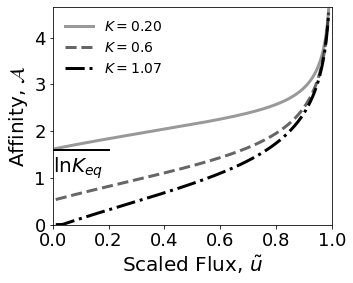

In [5]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3

ax.plot(fluxes[1:-1], data_a[10][1:-1],color='k',alpha=0.4,linewidth=width, label = r'$K=0.20$')
ax.plot(fluxes[1:-1], data_a[50][1:-1],color='k',alpha=0.6,linewidth=width, linestyle='--', label = r'$K=0.6$')
ax.plot(fluxes[1:-1], data_a[98][1:-1],color='k',alpha=1,linewidth=width, linestyle='-.',label = r'$K=1.07$')

ax.set_xlim(0,1)
ax.set_ylim(0,4.65)

ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon=False, loc='best', fontsize=14)

ax.plot([-0.05, 0.2], [1.6, 1.6], color='k', linestyle='-', linewidth=2)

ax.annotate(r"$\ln{K_{eq}}$", fontsize=20, xycoords='figure fraction', xy=(0.15, 0.39))

ax.set_xlabel(r'Scaled Flux, $\tilde{u}$', fontsize=20)
ax.set_ylabel(r'Affinity, $\mathcal{A}$', fontsize=20)

#plt.savefig('Affinity-flux.png',bbox_inches='tight')
#plt.savefig('Affinity-flux.pdf', bbox_inches='tight')

Steady-state requires net forward flux, i.e. that $\mathcal{A}>0$. For some parameter choices, this yields a minimum value of the scaled flux, $\tilde{u}$. 

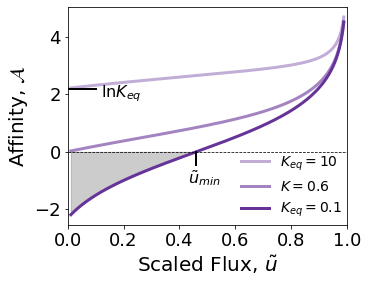

In [316]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3

ax.plot(fluxes[1:-1], data_a[1][1:-1],color='rebeccapurple',alpha=0.4,linewidth=width, label = r'$K_{eq} = 10$')
ax.plot(fluxes[1:-1], data_a[90][1:-1],color='rebeccapurple',alpha=0.6,linewidth=width, linestyle='-', label = r'$K=0.6$')
ax.plot(fluxes[1:-1], data_a[998][1:-1],color='rebeccapurple',alpha=1,linewidth=width, linestyle='-',label = r'$K_{eq} = 0.1$')

ax.set_xlim(0,1)
#ax.set_ylim(0,4.65)

ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon=False, loc=(0.6,-0), fontsize=14)

ax.plot([-0.05, 0.1], [2.2, 2.2], color='k', linestyle='-', linewidth=2)
ax.annotate(r"$\ln{K_{eq}}$", fontsize=16, xy=(0.12, 1.9))

ax.plot([0.46, 0.46], [0, -0.45], color='k', linestyle='-', linewidth=2)
ax.annotate(r"$\tilde{u}_{min}$", fontsize=16, xy=(0.43, -1.1))

plt.fill_between(
        x= fluxes[1:460],
        y1 = data_a[998][1:460],
        color= "k",
        alpha= 0.2)

ax.axhline(0, linewidth=0.75, linestyle='--',color='k')

ax.set_xlabel(r'Scaled Flux, $\tilde{u}$', fontsize=20)
ax.set_ylabel(r'Affinity, $\mathcal{A}$', fontsize=20)

#plt.savefig('Affinity-flux.png',bbox_inches='tight')
#plt.savefig('Affinity-flux.pdf', bbox_inches='tight')

In [332]:
Keq[200]

2.0819819819819823

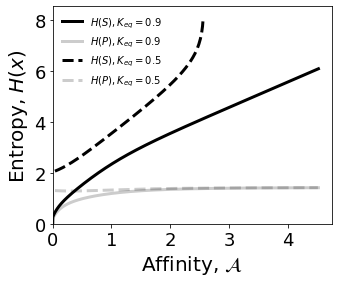

In [353]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3

ax.plot(data_a[100][:-1], entropyS[100][:-1],color='k', alpha = 1, linewidth=width, label = r'$H(S), K_{eq} = 0.9$')
ax.plot(data_a[100][:-1], entropyP[100][:-1],color='k', alpha = 0.2, linewidth=width, label = r'$H(P), K_{eq} = 0.9$')

ax.plot(data_a[200][290:-1], entropyS[200][290:-1],color='k', 
        alpha = 1, linewidth=width, linestyle = '--', label = r'$H(S), K_{eq} = 0.5$')
ax.plot(data_a[200][290:-1], entropyP[200][290:-1],color='k', 
        alpha = 0.2, linewidth=width, linestyle='--', label = r'$H(P), K_{eq} = 0.5$')

ax.set_xlim(0,)
ax.set_ylim(0,)

ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon=False, loc='best', fontsize=10)

plt.locator_params(axis='both', nbins=5) 

ax.set_xlabel(r'Affinity, $\mathcal{A}$', fontsize=20)
ax.set_ylabel(r'Entropy, $H(x)$', fontsize=20)


plt.savefig('entropies.png',bbox_inches='tight')
plt.savefig('entropies.pdf', bbox_inches='tight')

Text(0.6, 0.6, '')

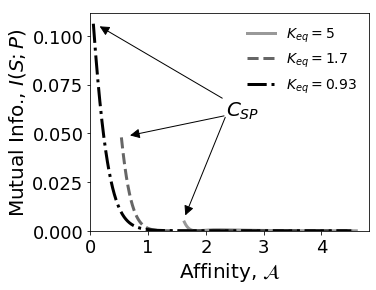

In [7]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3
color = 'k'

ax.plot(data_a[10][1:-1], data[10][1:-1],color=color,
        alpha=0.4,linewidth=width, label = r'$K_{eq} = 5$')
ax.plot(data_a[50][1:-1], data[50][1:-1],color=color,
        alpha=0.6,linewidth=width, linestyle = '--', label = r'$K_{eq} = 1.7$')
ax.plot(data_a[98][50:-1], data[98][50:-1],color=color,
        alpha=1,linewidth=width, linestyle = '-.', label = r'$K_{eq} = 0.93$')
#ax.plot(data_a[98][50:-1], data_ent[98][50:-1],linewidth=width)

ax.set_xlim(0,)
ax.set_ylim(0,)

ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon=False, loc='best', fontsize=14)

plt.locator_params(axis='both', nbins=5) 

ax.set_xlabel(r'Affinity, $\mathcal{A}$', fontsize=20)
ax.set_ylabel(r'Mutual Info., $I(S;P)$', fontsize=20)

#ax.annotate(r'$E_{T,R}/E = 2$',xy=(0.6, 0.82), xycoords='figure fraction', rotation = 0, fontsize=16)

ax.annotate(r"$C_{SP}$", fontsize=20,xycoords='figure fraction', xy=(0.26, 0.91), 
            xytext=(0.6, 0.6), arrowprops=dict(arrowstyle="-|>", color='k'))
ax.annotate(r"", fontsize=20, xycoords='figure fraction', xy=(0.34, 0.53),
            xytext=(0.6, 0.6), arrowprops=dict(arrowstyle="-|>", color='k'))
ax.annotate(r"", fontsize=20, xycoords='figure fraction', xy=(0.49, 0.25), 
            xytext=(0.6, 0.6), arrowprops=dict(arrowstyle="-|>", color='k'))

#plt.savefig('Catalytic info.png',bbox_inches='tight')
#plt.savefig('Catalytic info.pdf', bbox_inches='tight')

The choice of $K$ defines the range of possible affinities, because at $\tilde{u} = 0$, $\mathcal{A} = -\ln{K} \propto \ln{K_{eq}}$. The operational range of reverse-favoured reactions (those with large $K$/small $K_{eq}$) is larger than that of forward-favoured reactions (small $K$/large $K_{eq}$). Because they can operate closer to equilibrium, these reactions have much larger maixmum possible $I(S;P)$ values.

For all values of $K$,$I(S;P)$ is maximized for operation as close to equilibrium as is possible, and is asymptotic to 0 as the reaction is driven from equilibrium.

Now, $k$ is varied over a reasonable range to understand the effects on the system. 

In [354]:
fluxes = np.linspace(0.01,0.99,1000)
Keq = np.linspace(0.1, 10, 1000)

k = 0.1

data01 = np.zeros((1000,1000),dtype=float)
data_a01 = np.zeros((1000,1000),dtype=float)

for i in range(0,999): # For a given equilibrium constant
    for j in range(0,999): # Across all possible fluxes
        affinity, C = system(fluxes[j], Keq[i], k)
        
        if affinity < 0: # Steady states are not possible for A < 0. See Supplemental Information
            continue
        else:
            corr = C[2]/(np.sqrt(C[0]*C[-1]))

            data01[i][j] = -0.5*np.log(1-corr**2)
            data_a01[i][j] = affinity
            
k = 5

data5 = np.zeros((1000,1000),dtype=float)
data_a5 = np.zeros((1000,1000),dtype=float)

for i in range(0,999): # For a given equilibrium constant
    for j in range(0,999): # Across all possible fluxes
        affinity, C = system(fluxes[j], Keq[i], k)
        
        if affinity < 0: # Steady states are not possible for A < 0. See Supplemental Information
            continue
        else:
            corr = C[2]/(np.sqrt(C[0]*C[-1]))

            data5[i][j] = -0.5*np.log(1-corr**2)
            data_a5[i][j] = affinity

k = 10

data10 = np.zeros((1000,1000),dtype=float)
data_a10 = np.zeros((1000,1000),dtype=float)

for i in range(0,999): # For a given equilibrium constant
    for j in range(0,999): # Across all possible fluxes
        affinity, C = system(fluxes[j], Keq[i], k)
        
        if affinity < 0: # Steady states are not possible for A < 0. See Supplemental Information
            continue
        else:
            corr = C[2]/(np.sqrt(C[0]*C[-1]))

            data10[i][j] = -0.5*np.log(1-corr**2)
            data_a10[i][j] = affinity

C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:11 RuntimeWarning: invalid value encountered in log
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:16 RuntimeWarning: invalid value encountered in sqrt
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:33 RuntimeWarning: invalid value encountered in sqrt


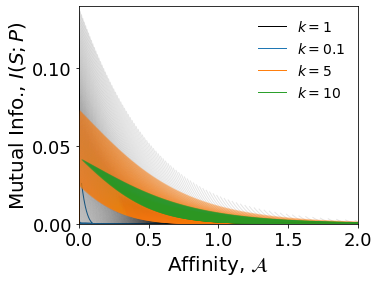

In [7]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 1

for i in range(0,999):
    if i == 1:
        ax.plot(data_a[i][:-1], data[i][:-1],color='k',alpha=1,linewidth=width, label=r'$k=1$')
        ax.plot(data_a01[i][:-1], data01[i][:-1],color='C00000',alpha=1,linewidth=width, label=r'$k=0.1$')
        ax.plot(data_a5[i][:-1], data5[i][:-1],color='C00001',alpha=1,linewidth=width, label=r'$k=5$')
        ax.plot(data_a10[i][:-1], data10[i][:-1],color='C00002',alpha=1,linewidth=width, label=r'$k=10$')
    else:
        ax.plot(data_a[i][:-1], data[i][:-1],color='k',alpha=0.1,linewidth=width)
        ax.plot(data_a01[i][:-1], data01[i][:-1],color='C00000',alpha=1,linewidth=width)
        ax.plot(data_a5[i][:-1], data5[i][:-1],color='C00001',alpha=0.1,linewidth=width)
        ax.plot(data_a10[i][:-1], data10[i][:-1],color='C00002',alpha=0.1,linewidth=width)

ax.set_xlim(-0,2)
ax.set_ylim(0,0.14)

ax.set_xlabel(r'Affinity, $\mathcal{A}$', fontsize=20)
ax.set_ylabel(r'Mutual Info., $I(S;P)$', fontsize=20)

ax.legend(frameon=False, loc='best', fontsize=14)

plt.locator_params(axis='both', nbins=5) 

ax.tick_params(axis='both', labelsize=18)

Changing $k$ from the nominal value of 1 always decreases $I(S;P)$. From this figure, it is clear that the maximum value of $I(S;P)$ for all parameter choices is a function of the affinity. This is the channel capacity, $C$, for information flow along the 'metabolic' channel, $C_{SP}$. 

$C_{SP}$ as a function of affinity is visualized in the next block.

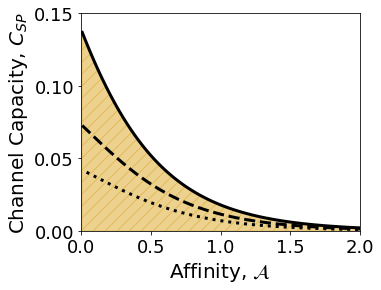

In [9]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3

ax.plot(data_a[:,0][0:93], data[:,0][0:93],color='k',alpha=1,linewidth=width, label=r'$k=1$')
ax.plot(data_a5[:,0][:505], data5[:,0][:505],color='k',alpha=1,linewidth=width, linestyle = '--', label=r'$k=5$')
ax.plot(data_a10[:,0][:-1], data10[:,0][:-1],color='k',alpha=1,linewidth=width,linestyle = ':',label=r'$k=10$')

plt.fill_between(
        x= data_a[:,0][0:93], 
        y1= data[:,0][0:93],
        color= "goldenrod",
        hatch = '//',
        alpha= 0.5)

ax.set_xlim(-0,2)
ax.set_ylim(0,0.15)

ax.set_xlabel(r'Affinity, $\mathcal{A}$', fontsize=20)
ax.set_ylabel(r'Channel Capacity, $C_{SP}$', fontsize=20)

#ax.legend(frameon=False, loc='best', fontsize=14)

plt.locator_params(axis='both', nbins=5) 

ax.tick_params(axis='both', labelsize=18)

#plt.savefig('catalytic envelope.png', bbox_inches='tight')
#plt.savefig('catalytic envelope.pdf', bbox_inches='tight')

Note that the $C_{SP}$ is a maximum - the system may operate below this value, so it defines an operation envelope. The shaded region in the above figure is this operation envelope.

A consequence of this relationship is that the parameter $K$ constrains the maximum possible information that can be transferred via this reaction. Regardless of the context, the channel capacity is largest when $K_{eq}$ is smallest. 

In [357]:
Csp_k01 = []
Csp_k5 = []
Csp = []
Csp_k10 = []

for i in range(0, 999):
    Csp_k01.append(data01[i][np.nonzero(data01[i])[0][0]])
    
    Csp_k5.append(data5[i][np.nonzero(data5[i])[0][0]])

    Csp.append(data[i][np.nonzero(data[i])[0][0]])
    
    Csp_k10.append(data10[i][np.nonzero(data10[i])[0][0]])

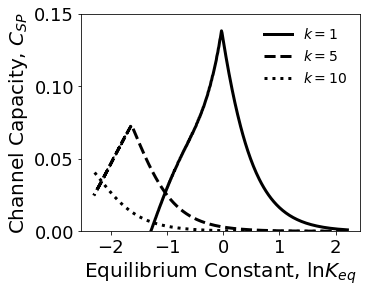

In [360]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3
color = 'k'

#ax.plot(-np.log(Keq[1:]), Csp_k01,color='k',alpha=1,linewidth=width, linestyle = '-.', label=r'$k=0.1$')
ax.plot(-np.log(Keq[1:]), Csp,color=color,alpha=1,linewidth=width, label=r'$k=1$')
ax.plot(-np.log(Keq[1:]), Csp_k5,color=color,alpha=1,linewidth=width, linestyle = '--', label=r'$k=5$')
ax.plot(-np.log(Keq[1:]), Csp_k10,color=color,alpha=1,linewidth=width,linestyle = ':',label=r'$k=10$')


#ax.set_xlim(-0,1)
ax.set_ylim(0,0.15)

ax.set_xlabel(r'Equilibrium Constant, $\ln{K_{eq}}$', fontsize=20)
ax.set_ylabel(r'Channel Capacity, $C_{SP}$', fontsize=20)

ax.legend(frameon=False, loc='best', fontsize=14)

plt.locator_params(axis='both', nbins=5) 

ax.tick_params(axis='both', labelsize=18)

plt.savefig('cap-keq.png', bbox_inches='tight')
plt.savefig('cap-keg.pdf', bbox_inches='tight')

For each choice of downstream turnover, channel capacity has a strong peak at some $K_{eq}$ value and declines on either side of that value. For higher downstream turnover rates, the peak $K_{eq}$ is shifted to smaller values and the peak channel capacity is reduced. Not shown is the curve for $k=0.1$, which has a negligible peak channel capacity at the largest $K_{eq}$ value.

## B. Expansion of the LNA framework to include regulatory interactions
The same reaction is considered, but now the substrate, $S$, can bind a regulated enzyme, $E_R$, to form a regulated complex, $E^*$. The mutual information between $S$ and $E^*$, $I(S;E)$, for various parameter sets across $K_{eq}$ values is evaluated in this section.

See the Supplemental Information for the nondimensionalization and explanation of this system in detail.

### B.1 The nominal case with a regulatory interaction
Initially the same system as above is considered, but augmented with an additional reaction in which $S$ binds to $E_R$. Similarly to the nominal system, steady state values are determined for all possible values of $\tilde{u} \in [0,1)$. For each steady state, the fluctuation-dissipation equation derived from LNA is used to find the mutual information between $\tilde{S}$ and $\tilde{P}$, $I(S;P)$, and between $\tilde{S}$ and $\tilde{E^*}$, $I(S;E)$.

In [12]:
def system_reg(u, k, kf, kr, krf, krr, Et, Ks):
    
    K = kr/kf
    
    P = u/k
    S = u/(1-u)*(1-P*(u-K))
    Er = krf/kf*Et*Ks*S/(krf/krr*Ks*S+1)
    
    mass_act = P/S*K

    affinity = -np.log(mass_act)
    
    e1 = krf/krr*Ks*Er*S
    e2 = krf/kf*Et*Ks*S
    
    dfdS = (1+P*(1-K))/(1+S+P)**2
    dfdP = (K+S*(K-1))/(1+S+P)**2
    
    A = np.array([[-dfdS - krf/kf*Et*Ks + krf/krr*Ks*Er, -dfdP, krf/krr*Ks*S+1],
                 [dfdS, dfdP-k, 0],
                 [krf/kf*Et*Ks-krf/krr*Ks*Er, 0, -(krf/krr*Ks*S+1)]])
    
    ACCAT = np.array([[2*A[0,0], A[0,1], A[0,2], A[0,1], 0, 0, A[0,2], 0, 0],
                     [A[1,0], A[0,0] + A[1,1], A[1,2], 0, A[0,1], 0, 0, A[0,2], 0],
                     [A[2,0], A[2,1], A[0,0] + A[2,2], 0, 0, A[0,1], 0, 0, A[0,2]],
                     [A[1,0], 0, 0, A[0,0] + A[1,1], A[0,1], A[0,2], A[1,2], 0, 0],
                     [0, A[1,0], 0, A[1,0], 2*A[1,1], A[2,2], 0, A[1,2], 0],
                     [0, 0, A[1,0], A[2,0], A[2,1], A[1,1] + A[2,2], 0, 0, A[1,2]],
                     [A[2,0], 0, 0, A[2,1], 0, 0, A[2,2] + A[0,0], A[0,1], A[0,2]],
                     [0, A[2,0], 0, 0, A[2,1], 0, A[1,0], A[2,2] + A[1,1], A[1,2]],
                     [0, 0, A[2,0], 0, 0, A[2,2], A[2,0], A[2,1], 2*A[2,2]]])
    
    BB_T = np.array([e1+Er+e2+2*u, -u, -(e1+e2+Er), -u, 2*u, 0, -(e2+e1+Er), 0, e1+e2+Er])
    
    C = np.linalg.solve(ACCAT,-BB_T)
    
    return affinity, C

In [361]:
fluxes = np.linspace(0.01,0.99,1000)
krs = np.linspace(0.1,10,1000)#0.05, 3, 1000)

k = 1
krf = 1
krr = 1
kf = 1
Ks = 1
Et = 1

data = np.zeros((1000,1000),dtype=float)
data_reg = np.zeros((1000,1000),dtype=float)
data_a = np.zeros((1000,1000),dtype=float)
entropyS = np.zeros((1000,1000),dtype=float)

for i in range(0,999): # For a given equilibrium constant
    for j in range(0,999): # Across all possible fluxes
        affinity, C = system_reg(fluxes[j], k, kf, krs[i], krf, krr, Et, Ks) #u, k, kf, kr, krf, krr, Et, Ks
        
        if affinity < 0:
            continue
        else:
            corr = C[1]/(np.sqrt(C[0]*C[4]))
            corr_reg = C[2]/(np.sqrt(C[0]*C[-1]))
            
            entropyS[i][j] = 0.5*np.log(2*pi*e*C[0])

            data[i][j] = -0.5*np.log(1-corr**2)
            data_reg[i][j] = -0.5*np.log(1-corr_reg**2)
            data_a[i][j] = affinity

C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:23 RuntimeWarning: invalid value encountered in sqrt
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:24 RuntimeWarning: invalid value encountered in sqrt
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:26 RuntimeWarning: invalid value encountered in log
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:29 RuntimeWarning: invalid value encountered in log


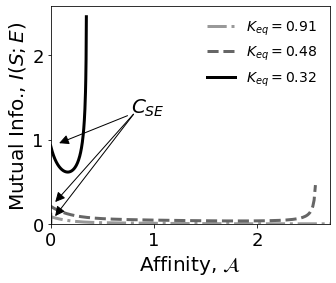

In [374]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3

ax.plot(data_a[100][:-1], data_reg[100][:-1],color='k',alpha=0.4, linewidth=width, linestyle = '-.',label = r'$K_{eq} = 0.91$')
ax.plot(data_a[200][:-1], data_reg[200][:-1],color='k',alpha=0.6,linewidth=width, linestyle = '--', label = r'$K_{eq} = 0.48$')
ax.plot(data_a[300][355:-1], data_reg[300][355:-1],color='k',alpha=1, linewidth=width, label = r'$K_{eq}=0.32$')

ax.set_xlim(0,2.7)
ax.set_ylim(0,)

ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon=False, loc='best', fontsize=14)

plt.locator_params(axis='both', nbins=5) 

ax.set_xlabel(r'Affinity, $\mathcal{A}$', fontsize=20)
ax.set_ylabel(r'Mutual Info., $I(S;E)$', fontsize=20)

ax.annotate(r"$C_{SE}$", fontsize=20,xycoords='figure fraction', xy=(0.17, 0.49),
            xytext=(0.39, 0.6), arrowprops=dict(arrowstyle="-|>", color='k'))
ax.annotate(r"", fontsize=20, xycoords='figure fraction', xy=(0.16, 0.28), 
            xytext=(0.4, 0.6), arrowprops=dict(arrowstyle="-|>", color='k'))
ax.annotate(r"", fontsize=20, xycoords='figure fraction', 
            xy=(0.16, 0.23), xytext=(0.4, 0.6), arrowprops=dict(arrowstyle="-|>", color='k'))


plt.savefig('reginfo-affinity.png',bbox_inches='tight')
plt.savefig('reginfo-affinity.pdf', bbox_inches='tight')

It is evident that $I(S;E) \rightarrow \infty$ as some maximum affinity value is approached. This asymptote appears to be different for different values of the equilibrium constant. This poses a challenge to finding a meaningful channel capacity for the $S$-$E_R$ interaction: $I(S;E)$ can be made arbitrarily large by forcing the system to operate more closely to the affinity asymptote (i.e., making $\tilde{u}$ abritrarly close to 1), but it is not biologically feasible to include the entire operating range, as $S$ accumulates very significantly for large $\tilde{u}$.

To address this, we take the equilibrium $I(S;E)$ value -- when $\mathcal{A} = 0$ -- as a meaninginful channel capacity. This value is a local maximum which is matched when $\tilde{u}$ is near the affinity asymptote. 

In the next blocks, the total enzyme regulated enzyme, $E_{R,T}$, is varied and the biologically meaningful channel capacities, $C_{SP}$ and $C_{SE}$, for each set of parameters is determined. 

C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:5 RuntimeWarning: invalid value encountered in true_divide
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:7 RuntimeWarning: invalid value encountered in true_divide
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:9 RuntimeWarning: invalid value encountered in true_divide


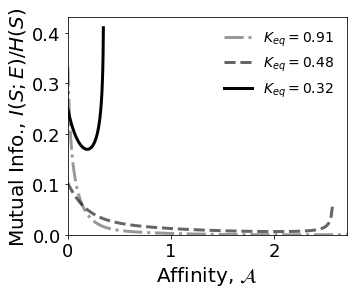

In [377]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3

ax.plot(data_a[100][:-1], np.divide(data_reg[100][:-1], entropyS[100][:-1])
        ,color='k',alpha=0.4, linewidth=width, linestyle = '-.',label = r'$K_{eq} = 0.91$')
ax.plot(data_a[200][:-1], np.divide(data_reg[200][:-1],entropyS[200][:-1])
        ,color='k',alpha=0.6,linewidth=width, linestyle = '--', label = r'$K_{eq} = 0.48$')
ax.plot(data_a[300][:-1], np.divide(data_reg[300][:-1],entropyS[300][:-1]),
        color='k',alpha=1, linewidth=width, label = r'$K_{eq}=0.32$')

ax.set_xlim(0,2.7)
ax.set_ylim(0,)

ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon=False, loc='best', fontsize=14)

plt.locator_params(axis='both', nbins=5) 

ax.set_xlabel(r'Affinity, $\mathcal{A}$', fontsize=20)
ax.set_ylabel(r'Mutual Info., $I(S;E)/H(S)$', fontsize=20)


plt.savefig('reginfo-affinity normed.png',bbox_inches='tight')
plt.savefig('reginfo-affinity normed.pdf', bbox_inches='tight')

In [378]:
fluxes = np.linspace(0.01,0.99,1000)
krs = np.linspace(0.1, 10, 1000)

k = 1
krf = 1
krr = 1
kf = 1
Ks = 1
Et = 0.5

data_e05 = np.zeros((1000,1000),dtype=float)
data_reg_e05 = np.zeros((1000,1000),dtype=float)
data_a_e05 = np.zeros((1000,1000),dtype=float)
entropy_e05 = np.zeros((1000,1000),dtype=float)

for i in range(0,999): # For a given equilibrium constant
    for j in range(0,999): # Across all possible fluxes
        affinity, C = system_reg(fluxes[j], k, kf, krs[i], krf, krr, Et, Ks) #u, k, kf, kr, krf, krr, Et, Ks
        
        if affinity < 0:
            continue
        else:
            corr = C[1]/(np.sqrt(C[0]*C[4]))
            corr_reg = C[2]/(np.sqrt(C[0]*C[-1]))
            
            entropy_e05[i][j] = 0.5*np.log(2*pi*e*C[0])

            data_e05[i][j] = -0.5*np.log(1-corr**2)
            data_reg_e05[i][j] = -0.5*np.log(1-corr_reg**2)
            data_a_e05[i][j] = affinity

k = 1
krf = 1
krr = 1
kf = 1
Ks = 1
Et = 1

data = np.zeros((1000,1000),dtype=float)
data_reg = np.zeros((1000,1000),dtype=float)
data_a = np.zeros((1000,1000),dtype=float)
entropy = np.zeros((1000,1000),dtype=float)

for i in range(0,999): # For a given equilibrium constant
    for j in range(0,999): # Across all possible fluxes
        affinity, C = system_reg(fluxes[j], k, kf, krs[i], krf, krr, Et, Ks) #u, k, kf, kr, krf, krr, Et, Ks
        
        if affinity < 0:
            continue
        else:
            corr = C[1]/(np.sqrt(C[0]*C[4]))
            corr_reg = C[2]/(np.sqrt(C[0]*C[-1]))
            
            entropy[i][j] = 0.5*np.log(2*pi*e*C[0])

            data[i][j] = -0.5*np.log(1-corr**2)
            data_reg[i][j] = -0.5*np.log(1-corr_reg**2)
            data_a[i][j] = affinity
            
k = 1
krf = 1
krr = 1
kf = 1
Ks = 1
Et = 2

data_e2 = np.zeros((1000,1000),dtype=float)
data_reg_e2 = np.zeros((1000,1000),dtype=float)
data_a_e2 = np.zeros((1000,1000),dtype=float)
entropy_e2 = np.zeros((1000,1000),dtype=float)

for i in range(0,999): # For a given equilibrium constant
    for j in range(0,999): # Across all possible fluxes
        affinity, C = system_reg(fluxes[j], k, kf, krs[i], krf, krr, Et, Ks) #u, k, kf, kr, krf, krr, Et, Ks
        
        if affinity < 0:
            continue
        else:
            corr = C[1]/(np.sqrt(C[0]*C[4]))
            corr_reg = C[2]/(np.sqrt(C[0]*C[-1]))
            
            entropy_e2[i][j] = 0.5*np.log(2*pi*e*C[0])

            data_e2[i][j] = -0.5*np.log(1-corr**2)
            data_reg_e2[i][j] = -0.5*np.log(1-corr_reg**2)
            data_a_e2[i][j] = affinity

C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:23 RuntimeWarning: invalid value encountered in sqrt
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:24 RuntimeWarning: invalid value encountered in sqrt
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:26 RuntimeWarning: invalid value encountered in log
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:29 RuntimeWarning: invalid value encountered in log
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:51 RuntimeWarning: invalid value encountered in sqrt
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:52 RuntimeWarning: invalid value encountered in sqrt
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:54 RuntimeWarning: invalid value encountered in log
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:57 RuntimeWarning: invalid value encountered in log
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launche

In [379]:
Csp_e05 = []
Cse_e05 = []

Csp = []
Cse = []

Csp_e2 = []
Cse_e2 = []

for i in range(0, 999):
    Csp_e05.append(data_e05[i][np.nonzero(data_e05[i])[0][0]])
    Cse_e05.append(data_reg_e05[i][np.nonzero(data_reg_e05[i])[0][0]])

    Csp.append(data[i][np.nonzero(data[i])[0][0]])
    Cse.append(data_reg[i][np.nonzero(data_reg[i])[0][0]])
    
    Csp_e2.append(data_e2[i][np.nonzero(data_e2[i])[0][0]])
    Cse_e2.append(data_reg_e2[i][np.nonzero(data_reg_e2[i])[0][0]])

Text(0, 0.5, 'Channel Capacity, $C_{Sx}$')

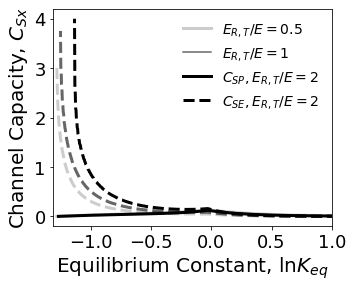

In [380]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3
color = 'k'

ax.plot(-np.log(krs[1:][:370]), Csp_e05[:370], color = color, alpha = 0.2, linewidth=width, label = r'$E_{R,T}/E = 0.5$')
ax.plot(-np.log(krs[1:][:370]), Cse_e05[:370], color = color, alpha = 0.2, linewidth=width, linestyle = '--')

ax.plot(-np.log(krs[1:][:350]), Csp[:350], color = color, alpha = 0.6, label = r'$E_{R,T}/E = 1$')
ax.plot(-np.log(krs[1:][:350]), Cse[:350], color = color, 
        alpha = 0.6, linewidth=width, linestyle = '--')

ax.plot(-np.log(krs[1:][:350]), Csp_e2[:350], color = color, alpha=1, linewidth=width, label = r'$C_{SP}, E_{R,T}/E = 2$')
ax.plot(-np.log(krs[1:][:350]), Cse_e2[:350], color = color, alpha = 1, linewidth=width, linestyle = '--', 
        label = r'$C_{SE}, E_{R,T}/E = 2$')

ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon=False, loc='best', fontsize=14)

plt.locator_params(axis='both', nbins=5) 

ax.set_xlim(-1.32,1)
ax.set_xlabel(r'Equilibrium Constant, $\ln{K_{eq}}$', fontsize=20)
ax.set_ylabel(r'Channel Capacity, $C_{Sx}$', fontsize=20)

#plt.savefig('cap-Keq reg.png',bbox_inches='tight')
#plt.savefig('cap-Keq reg.pdf', bbox_inches='tight')

Text(0, 0.5, 'Channel Capacity, $C_{Sx}$')

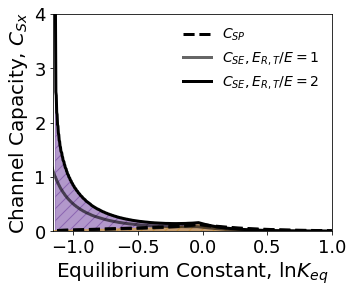

In [429]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3

ax.plot(-np.log(krs[1:][:350]), Csp[:350], color = 'k', alpha = 1, linewidth=width, linestyle='--', label = r'$C_{SP}$')
ax.plot(-np.log(krs[1:][:350]), Cse[:350], color = 'k', alpha = 0.6, linewidth=width, label='$C_{SE}, E_{R,T}/E = 1$')

ax.plot(-np.log(krs[1:][:350]), Csp_e2[:350], color = 'k', alpha=0.8, linewidth=width, linestyle ='--')
ax.plot(-np.log(krs[1:][:350]), Cse_e2[:350], color = 'k', alpha = 1, linewidth=width, linestyle = '-', 
        label = r'$C_{SE}, E_{R,T}/E = 2$')

plt.fill_between(
        x= -np.log(krs[1:][:350]), 
        y1= Cse_e2[:350],
        color= "rebeccapurple",
        hatch = '//',
        alpha= 0.5)

plt.fill_between(
        x= -np.log(krs[1:][:350]), 
        y1= Csp_e2[:350],
        color= "goldenrod",
        hatch = '//',
        alpha= 0.5)

ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon=False, loc='best', fontsize=14)

plt.locator_params(axis='both', nbins=5) 

ax.set_xlim(-1.16,1)
ax.set_ylim(0,4)
ax.set_xlabel(r'Equilibrium Constant, $\ln{K_{eq}}$', fontsize=20)
ax.set_ylabel(r'Channel Capacity, $C_{Sx}$', fontsize=20)

#plt.savefig('cap-Keq reg for pub.png',bbox_inches='tight')
#plt.savefig('cap-Keq reg for pub.pdf', bbox_inches='tight')

ValueError: operands could not be broadcast together with shapes (370,) (370,1000) 

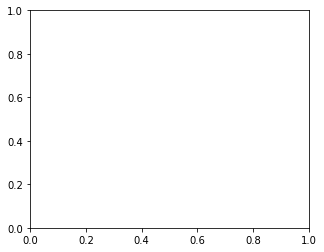

In [381]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3
color = 'k'

ax.plot(-np.log(krs[1:][:370]), np.divide(Csp_e05[:370], entropy_e05[:370]), 
        color = color, alpha = 0.2, linewidth=width, label = r'$E_{R,T}/E = 0.5$')
ax.plot(-np.log(krs[1:][:370]), np.divide(Cse_e05[:370], entropy_e05[:370]), 
        color = color, alpha = 0.2, linewidth=width, linestyle = '--')

ax.plot(-np.log(krs[1:][:350]), np.divide(Csp[:350], entropy[:350]), color = color, alpha = 0.6, label = r'$E_{R,T}/E = 1$')
ax.plot(-np.log(krs[1:][:350]), np.divide(Cse[:350], entropy[:350]), color = color, 
        alpha = 0.6, linewidth=width, linestyle = '--')

ax.plot(-np.log(krs[1:][:350]), np.divide(Csp_e2[:350], entropy_e2[:350]), 
        color = color, alpha=1, linewidth=width, label = r'$C_{SP}, E_{R,T}/E = 2$')
ax.plot(-np.log(krs[1:][:350]), np.divide(Cse_e2[:350], entropy_e2[:350]), 
        color = color, alpha = 1, linewidth=width, linestyle = '--', label = r'$C_{SE}, E_{R,T}/E = 2$')

ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon=False, loc='best', fontsize=14)

plt.locator_params(axis='both', nbins=5) 

ax.set_xlim(-1.32,1)
ax.set_xlabel(r'Equilibrium Constant, $\ln{K_{eq}}$', fontsize=20)
ax.set_ylabel(r'Channel Capacity, $C_{Sx}$', fontsize=20)

#plt.savefig('cap-Keq reg.png',bbox_inches='tight')
#plt.savefig('cap-Keq reg.pdf', bbox_inches='tight')

$C_{SP}$ is maximized when $K_{eq} = 1$, i.e. when the forward and reverse reactions are equally favourable, with all other parameter values being nominal. As before, this peak is shifted with increases downstream turnover. Regardless, $C_{SP}$ drops off on either side of this value of $K_{eq}$. In contrast, $C_{SE}$ increases for increasingly reverse-favourability (i.e., as $K_{eq} \rightarrow 0$). In fact, it appears to be asymptotic as the system is operated closer to the lower bound on $K_{eq}$. As shown in the next block, mutual information approaches infinity for perfect correlation, so the asymptotic behaviour of $C_{SE}$ simply means that $E^*$ is perfectly correlated to $S$ for highly reverse-favoured reactions.

Therefore, the equilibrium constant, $K_{eq}$, is a true constraint on information flow for open systems with balanced flux! This constraint can be gotten around by having $S$ bind to a regulatory protein. In fact, perfect information transfer is thereotically possible for regulatory interactions involving substrates of highly reverse-favoured reactions. We note, however, that this analysis does not include the effects of noise, which would likely prevent truly perfect information transfer in real systems.

### B.2 Cooperative regulation
Many (perhaps most!) regulatory interactions are cooperative. This scenario is examined in the next few blocks by considering the case in which $S$ binds to $E_R$ with stoichiometry $\eta > 1$. 

In [27]:
def system_regn(u, k, kf, kr, krf, krr, Et, Ks, n):
    
    K = kr/kf
    
    P = u/k
    S = u/(1-u)*(1-P*(u-K))
    Er = krf/kf*Et*Ks*n*S**n/(krf/krr*Ks*n*S**n+1)
    
    mass_act = P/S*K

    affinity = -np.log(mass_act)
    
    e1 = krf/krr*Ks*Er*n*S**n
    e2 = krf/kf*Et*Ks*n*S**n
    
    dfdS = (1+P*(1-K))/(1+S+P)**2
    dfdP = (K+S*(K-1))/(1+S+P)**2
    
    A = np.array([[-dfdS - krf/kf*Et*Ks*n*S**(n-1)+ krf/krr*Ks*Er*n*S**(n-1), -dfdP, krf/krr*Ks*n*S**n+1],
                 [dfdS, dfdP-k, 0],
                 [krf/kf*Et*Ks*n*S**(n-1)-krf/krr*Ks*Er*n*S**(n-1), 0, -(krf/krr*Ks*n*S**n+1)]])
    
    ACCAT = np.array([[2*A[0,0], A[0,1], A[0,2], A[0,1], 0, 0, A[0,2], 0, 0],
                     [A[1,0], A[0,0] + A[1,1], A[1,2], 0, A[0,1], 0, 0, A[0,2], 0],
                     [A[2,0], A[2,1], A[0,0] + A[2,2], 0, 0, A[0,1], 0, 0, A[0,2]],
                     [A[1,0], 0, 0, A[0,0] + A[1,1], A[0,1], A[0,2], A[1,2], 0, 0],
                     [0, A[1,0], 0, A[1,0], 2*A[1,1], A[2,2], 0, A[1,2], 0],
                     [0, 0, A[1,0], A[2,0], A[2,1], A[1,1] + A[2,2], 0, 0, A[1,2]],
                     [A[2,0], 0, 0, A[2,1], 0, 0, A[2,2] + A[0,0], A[0,1], A[0,2]],
                     [0, A[2,0], 0, 0, A[2,1], 0, A[1,0], A[2,2] + A[1,1], A[1,2]],
                     [0, 0, A[2,0], 0, 0, A[2,2], A[2,0], A[2,1], 2*A[2,2]]])
    
    BB_T = np.array([e1+Er+e2+2*u, -u, -(e1+e2+Er), -u, 2*u, 0, -(e2+e1+Er), 0, e1+e2+Er])
    
    C = np.linalg.solve(ACCAT,-BB_T)
    
    return affinity, C

In [47]:
fluxes = np.linspace(0.01,0.99,1000)
krs = np.linspace(0.1, 10, 1000)

k = 1
krf = 1
krr = 1
kf = 1
Ks = 1
Et = 2
n = 2

data_n2 = np.zeros((1000,1000),dtype=float)
data_reg_n2 = np.zeros((1000,1000),dtype=float)
data_a_n2 = np.zeros((1000,1000),dtype=float)

for i in range(0,999): # For a given equilibrium constant
    for j in range(0,999): # Across all possible fluxes
        affinity, C = system_regn(fluxes[j], k, kf, krs[i], krf, krr, Et, Ks, n) #u, k, kf, kr, krf, krr, Et, Ks
        
        if affinity < 0:
            continue
        else:
            corr = C[1]/(np.sqrt(C[0]*C[4]))
            corr_reg = C[2]/(np.sqrt(C[0]*C[-1]))
            

            data_n2[i][j] = -0.5*np.log(1-corr**2)
            data_reg_n2[i][j] = -0.5*np.log(1-corr_reg**2)
            data_a_n2[i][j] = affinity

C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:23 RuntimeWarning: invalid value encountered in sqrt
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:24 RuntimeWarning: invalid value encountered in sqrt
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:28 RuntimeWarning: invalid value encountered in log


In [526]:
fluxes = np.linspace(0.01,0.99,1000)
krs = np.linspace(0.1, 10, 1000)

k = 1
krf = 1
krr = 1
kf = 1
Ks = 1
Et = 1
n = 2

data_n2 = np.zeros((1000,1000),dtype=float)
data_reg_n2 = np.zeros((1000,1000),dtype=float)
data_a_n2 = np.zeros((1000,1000),dtype=float)

for i in range(0,999): # For a given equilibrium constant
    for j in range(0,999): # Across all possible fluxes
        affinity, C = system_regn(fluxes[j], k, kf, krs[i], krf, krr, Et, Ks, n) #u, k, kf, kr, krf, krr, Et, Ks
        
        if affinity < 0:
            continue
        else:
            corr = C[1]/(np.sqrt(C[0]*C[4]))
            corr_reg = C[2]/(np.sqrt(C[0]*C[-1]))
            

            data_n2[i][j] = -0.5*np.log(1-corr**2)
            data_reg_n2[i][j] = -0.5*np.log(1-corr_reg**2)
            data_a_n2[i][j] = affinity
            
k = 1
krf = 1
krr = 1
kf = 1
Ks = 1
Et = 2
n=2

data_e2n2 = np.zeros((1000,1000),dtype=float)
data_reg_e2n2 = np.zeros((1000,1000),dtype=float)
data_a_e2n2 = np.zeros((1000,1000),dtype=float)

for i in range(0,999): # For a given equilibrium constant
    for j in range(0,999): # Across all possible fluxes
        affinity, C = system_regn(fluxes[j], k, kf, krs[i], krf, krr, Et, Ks, n) #u, k, kf, kr, krf, krr, Et, Ks
        
        if affinity < 0:
            continue
        else:
            corr = C[1]/(np.sqrt(C[0]*C[4]))
            corr_reg = C[2]/(np.sqrt(C[0]*C[-1]))
            

            data_e2n2[i][j] = -0.5*np.log(1-corr**2)
            data_reg_e2n2[i][j] = -0.5*np.log(1-corr_reg**2)
            data_a_e2n2[i][j] = affinity

C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:23 RuntimeWarning: invalid value encountered in sqrt
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:24 RuntimeWarning: invalid value encountered in sqrt
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:28 RuntimeWarning: invalid value encountered in log
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:50 RuntimeWarning: invalid value encountered in sqrt
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:51 RuntimeWarning: invalid value encountered in sqrt
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:55 RuntimeWarning: invalid value encountered in log
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:77 RuntimeWarning: invalid value encountered in sqrt
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:78 RuntimeWarning: invalid value encountered in sqrt
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launc

In [48]:
Csp_n2 = []
Cse_n2 = []

Csp_e2n2 = []
Cse_e2n2 = []

for i in range(0, 999):
    Csp_n2.append(data_n2[i][np.nonzero(data_n2[i])[0][0]])
    Cse_n2.append(data_reg_n2[i][np.nonzero(data_reg_n2[i])[0][0]])
    
    Csp_e2n2.append(data_n2[i][np.nonzero(data_n2[i])[0][0]])
    Cse_e2n2.append(data_reg_n2[i][np.nonzero(data_reg_n2[i])[0][0]])

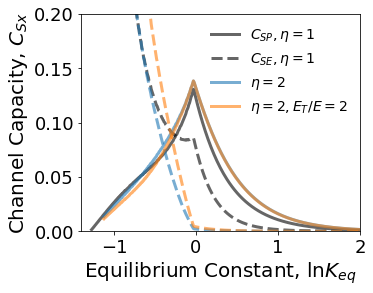

In [58]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3

ax.plot(-np.log(krs[1:][:350]), Csp[:350], color = 'k', alpha = 0.6, linewidth=width, label = r'$C_{SP}, \eta = 1$')
ax.plot(-np.log(krs[1:][:350]), Cse[:350], color = 'k', alpha = 0.6, 
        linewidth=width, linestyle = '--', label = r'$C_{SE}, \eta = 1$')

ax.plot(-np.log(krs[1:][0:300]), Csp_n2[0:300], color = 'C00000', alpha = 0.6, linewidth=width, label = r'$\eta = 2$')
ax.plot(-np.log(krs[1:][0:300]), Cse_n2[0:300], color = 'C00000', 
        alpha = 0.6, linewidth=width, linestyle = '--')

ax.plot(-np.log(krs[1:][0:300]), Csp_e2n2[0:300], color = 'C00001', alpha = 0.6, linewidth=width, label = r'$\eta = 2, E_T/E = 2$')
ax.plot(-np.log(krs[1:][0:300]), Cse_e2n2[0:300], color = 'C00001', alpha = 0.6, linewidth=width, linestyle = '--')


ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon=False, loc='best', fontsize=14)

plt.locator_params(axis='both', nbins=5) 

ax.set_ylim(0,0.2)
ax.set_xlim(-1.4,2)
ax.set_xlabel(r'Equilibrium Constant, $\ln{K_{eq}}$', fontsize=20)
ax.set_ylabel(r'Channel Capacity, $C_{Sx}$', fontsize=20)

plt.savefig('cooperativity.pdf', bbox_inches='tight')
plt.savefig('cooperativity.png', bbox_inches='tight')

The behaviour of the system with cooperativity follows the same general trend as that without: for low $K_{eq}$ values, the regulatory channel capcity is maximized. However, the transition to the "regulation-dominated" regime occurs more sharply when there is cooperativity. The benefit of cooperative regulatory interactions may not be information maximization - rather, there may be other constraints leading to cooperativity. 

### B.3 Feedforward activation

The above analysis assumes that the regulatory interaction has no direct impact on the turnover rate of $S$ or $P$, i.e. that it is completely independent of the pathway. There are important examples in which the regulatory signal is part of a feedforward activation (FFA) loop which controls the turnover rate of $P$. A good example is the case of pyruvate kinase activation by fructose-1,6-bisphosphate, a motif common to many metabolisms. Therefore, in this section FFA is considered.

In this case, the mass balance becomes

\begin{equation}
    \frac{dS}{dt} = u - k^+E \frac{S/K_S}{1+S/K_S+P/K_P}\left(1-\frac{P/S}{K_{eq}}\right)
\end{equation}

\begin{equation}
    \frac{dP}{dt} = k^+E \frac{S/K_S}{1+S/K_S+P/K_P}\left(1-\frac{P/S}{K_{eq}}\right) - \left(1+\frac{S}{K_A+S}\right)k_0P
\end{equation}

Because $\bar{P} = \frac{u}{\left(1+\frac{S}{K_A+S}\right)k_0} = f(\bar{S})$ for this system, there is no simple closed-form expression for $\bar{S}$. Instead, the system must be solved numerically. This is done for various $K_{eq}$ values in the next few blocks.

In [64]:
# Define new rate equations which include the feedforward activation interaction

def FFA(x,t,k):
    
    #k[0] = u
    #k[1] = K
    #k[2] = k
    
    dSdt = k[0] - x[0]/(1+x[0]+x[1])*(1-x[1]/x[0]*k[1])
    dPdt = x[0]/(1+x[0]+x[1])*(1-x[1]/x[0]*k[1]) - (1+x[0]/(1+x[0]))*k[2]*x[1]
    
    return [dSdt, dPdt]

# Define new matrices for LNA      
                
def system_FFA(u, K, k, t):
    
    m = [u, K, k]
    x0 = [0.01, 0]
    
    y = odeint(FFA, x0, t, args = (m,))
    
    P = y[-1][1]
    S = y[-1][0]
    
    mass_act = P/S*K

    affinity = -np.log(mass_act)
    
    dfdS = (1+P*(1-K))/(1+S+P)**2
    dfdP = (K+S*(K-1))/(1+S+P)**2
    
    A = np.array([[-dfdS, -dfdP],
                 [dfdS, dfdP-k]])
    
    ACCAT = np.array([[2*A[0,0], A[0,1], A[0,1],0],
                     [A[1,0], A[0,0]+A[1,1], 0, A[0,1]],
                     [A[1,0], 0, A[0,0]+A[1,1], A[0,1]],
                     [0, A[1,0], A[1,0], 2*A[1,1]]])
    
    BB_T = np.array([2*u, -u, -u, 2*u])
    
    C = np.linalg.solve(ACCAT,-BB_T)
    
    return affinity, C

In [121]:
n = 100
t = np.linspace(0,1000,n)
fluxes = np.linspace(0.01,0.99,100)
Keq = np.linspace(0.1, 10, 100)

k = 0.5

data_FFA = np.zeros((100,100),dtype=float)
data_a_FFA = np.zeros((100,100),dtype=float)

for i in range(0,99): # For a given equilibrium constant
    for j in range(0,99): # Across all possible fluxes
        affinity, C = system_FFA(fluxes[j], Keq[i], k, t)
        
        if affinity < 0:
            continue
        else:
            corr = C[1]/(np.sqrt(C[0]*C[-1]))

            data_FFA[i][j] = -0.5*np.log(1-corr**2)
            data_a_FFA[i][j] = affinity

C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:18 RuntimeWarning: invalid value encountered in sqrt


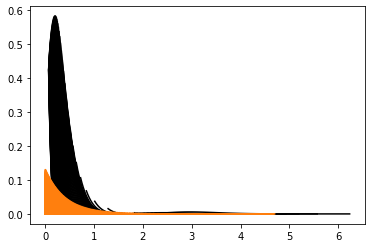

In [83]:
for i in range(0,99):
    plt.plot(data_a_FFA[i][:-1],data_FFA[i][:-1], color='k')

for i in range(0,999):
    plt.plot(data_a[i][:-1],data[i][:-1], color='C00001')

In [122]:
Csp_FFA = []

for i in range(0, 99):
    Csp_FFA.append(data_FFA[i][np.nonzero(data_FFA[i])[0][0]])

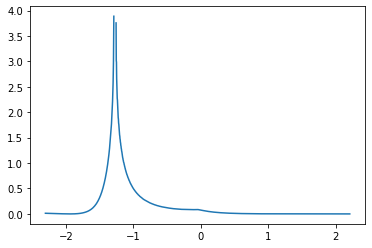

In [126]:
#plt.plot(-np.log(Keq[1:]), Csp_FFA)
#plt.plot(-np.log(krs[1:]), Csp)
plt.plot(-np.log(krs[1:]), Cse)

#plt.ylim(0,1)

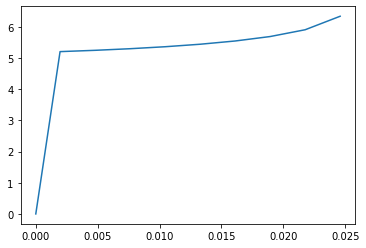

In [112]:
plt.plot(data_a[350][:-1], data_ent[350][:-1])

In [124]:
Csp[355]

nan

In [116]:
data_a[350]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [ ]:
## fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3

#ax.plot(-np.log(krs[1:]), Csp_n2, color = 'k', alpha = 0.6, linewidth=width, label = r'$\eta = 2$')
#ax.plot(-np.log(krs[1:]), Cse_n2, color = 'k', alpha = 0.6, linewidth=width, linestyle = '--')

#ax.plot(-np.log(krs[1:]), Csp, color = 'k', alpha = 0.8, linewidth=width, label = r'$\eta = 1$')
#ax.plot(-np.log(krs[1:]), Cse, color = 'k', alpha = 0.8, linewidth=width, linestyle = '--')

ax.plot(-np.log(krs[1:]), Csp_e2n2, color = 'k', alpha=1, linewidth=width, label = r'$\eta = 2; E_{R,T}/E = 2$')
ax.plot(-np.log(krs[1:]), Cse_e2n2, color = 'k', alpha = 1, linewidth=width, linestyle = '--')

ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon=False, loc='best', fontsize=14)

plt.locator_params(axis='both', nbins=5) 

ax.set_ylim(0,1)
ax.set_xlim(-1.4,1.37)
ax.set_xlabel(r'Equilibrium Constant, $\ln{K}$', fontsize=20)
ax.set_ylabel(r'Channel Capacity, $C_{Sx}$', fontsize=20)

#plt.savefig('cap-Keq reg k2.png',bbox_inches='tight')
#plt.savefig('cap-Keq reg k2.pdf', bbox_inches='tight')

In [641]:
def system_regFFA(u, k, kf, kr, krf, krr, Et, Ks, n):
    
    K = kr/kf
    
    S = u/(1-u)*(1-u/k*(u-K))
    P = u/((1+S/(S+10))*k)
    Er = krf/kf*Et*Ks*n*S**n/(krf/krr*Ks*n*S**n+1)
    
    mass_act = P/S*K

    affinity = -np.log(mass_act)
    
    e1 = krf/krr*Ks*Er*n*S**n
    e2 = krf/kf*Et*Ks*n*S**n
    
    dfdS = (1+P*(1-K))/(1+S+P)**2
    dfdP = (K+S*(K-1))/(1+S+P)**2
    
    A = np.array([[-dfdS - krf/kf*Et*Ks*n*S**(n-1)+ krf/krr*Ks*Er*n*S**(n-1), -dfdP, krf/krr*Ks*n*S**n+1],
                 [dfdS, dfdP-1/(S+1)**2*k, 0],
                 [krf/kf*Et*Ks*n*S**(n-1)-krf/krr*Ks*Er*n*S**(n-1), 0, -(krf/krr*Ks*n*S**n+1)]])
    
    ACCAT = np.array([[2*A[0,0], A[0,1], A[0,2], A[0,1], 0, 0, A[0,2], 0, 0],
                     [A[1,0], A[0,0] + A[1,1], A[1,2], 0, A[0,1], 0, 0, A[0,2], 0],
                     [A[2,0], A[2,1], A[0,0] + A[2,2], 0, 0, A[0,1], 0, 0, A[0,2]],
                     [A[1,0], 0, 0, A[0,0] + A[1,1], A[0,1], A[0,2], A[1,2], 0, 0],
                     [0, A[1,0], 0, A[1,0], 2*A[1,1], A[2,2], 0, A[1,2], 0],
                     [0, 0, A[1,0], A[2,0], A[2,1], A[1,1] + A[2,2], 0, 0, A[1,2]],
                     [A[2,0], 0, 0, A[2,1], 0, 0, A[2,2] + A[0,0], A[0,1], A[0,2]],
                     [0, A[2,0], 0, 0, A[2,1], 0, A[1,0], A[2,2] + A[1,1], A[1,2]],
                     [0, 0, A[2,0], 0, 0, A[2,2], A[2,0], A[2,1], 2*A[2,2]]])
    
    BB_T = np.array([e1+Er+e2+2*u, -u, -(e1+e2+Er), -u, 2*u, 0, -(e2+e1+Er), 0, e1+e2+Er])
    
    C = np.linalg.solve(ACCAT,-BB_T)
    
    return affinity, C

In [642]:
fluxes = np.linspace(0.01,0.99,1000)
krs = np.linspace(0.1, 10, 1000)

k = 1
krf = 1
krr = 1
kf = 1
Ks = 1
Et = 1
n = 1

data_FFA = np.zeros((1000,1000),dtype=float)
data_reg_FFA = np.zeros((1000,1000),dtype=float)
data_a_FFA = np.zeros((1000,1000),dtype=float)

for i in range(0,999): # For a given equilibrium constant
    for j in range(0,999): # Across all possible fluxes
        affinity, C = system_regFFA(fluxes[j], k, kf, krs[i], krf, krr, Et, Ks, n) #u, k, kf, kr, krf, krr, Et, Ks
        
        if affinity < 0:
            continue
        else:
            corr = C[1]/(np.sqrt(C[0]*C[4]))
            corr_reg = C[2]/(np.sqrt(C[0]*C[-1]))
            

            data_FFA[i][j] = -0.5*np.log(1-corr**2)
            data_reg_FFA[i][j] = -0.5*np.log(1-corr_reg**2)
            data_a_FFA[i][j] = affinity

C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:28 RuntimeWarning: invalid value encountered in log
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:24 RuntimeWarning: invalid value encountered in sqrt
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:23 RuntimeWarning: invalid value encountered in sqrt
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:27 RuntimeWarning: invalid value encountered in log


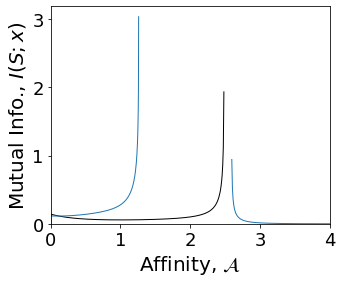

In [643]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 1

for i in range(99,100):
    ax.plot(data_a_FFA[i][:-1], data_FFA[i][:-1],color='k',alpha=1,linewidth=width)
    ax.plot(data_a_FFA[i][:-1], data_reg_FFA[i][:-1],color='C00000',alpha=1,linewidth=width)
    #ax.plot(data_a[i][:-1], data_ent[i][:-1],color='C00001',alpha=0.1,linewidth=width)

ax.set_xlim(0,4)
ax.set_ylim(0,)

ax.set_xlabel(r'Affinity, $\mathcal{A}$', fontsize=20)
ax.set_ylabel(r'Mutual Info., $I(S;x)$', fontsize=20)

plt.locator_params(axis='both', nbins=5) 

ax.tick_params(axis='both', labelsize=18)

In [638]:
data_FFA[100][-140]

0.8442636592807902

### B.3 Some sensitivity analysis
Though we have considered variation in the "important" parameters already, for completeness we examine the effect of varying the remaining parameters here. The figures produced from this section can be found in the Supplemental Information. 

## C. Analysis of pre-existing -omics data
In this section, -omics and thermodynamic data are used to correlate the role of metabolites as regulators with the thermodynamics of the reactions in which they are involved.

### C.1 Genome-scale analysis
All regulators are parsed from the BRENDA database, then assigned to reactions using genome-scale metabolic models. Thermodynamic parameters are assigned to reactions, and the correlation between regulatory status and reaction reversibility is determined. This analysis is performed for E. coli, B. bacillus, P. putida, S. cerevisiae, M. musculus, and H. sapiens. H. sapiens and M. musculus analyses are not in the final publication because there was insufficient data to draw meaningful conclusions for these organisms.

In [2]:
os.chdir('C:\\Users\\euler\\Documents\\PhD\\New Information\\Communications Biology\\Data and Code')

To our knowledge, there is no up-to-date API for parsing BRENDA. As such, the database should be downloaded as a .txt file. A download is available in the repository associated with this project.

In [ ]:
#Reads in downloaded BRENDA database and splits it into individual entries, with modification of first entry to make it uniform 
#for next step

f = open('brenda_download.txt','r',encoding="utf8")
page=f.read()
f.close()

BRENDA = page.split('///')
BRENDA[0]='\n'+BRENDA[0]

The next block of code parses the BRENDA .txt file for regulators and assembles the data into a dataframe. This code is likely very inefficient and will take some time to run, so we suggest doing it just once. We have also included the parsed data in a .xlsx file in the repository associated with this project.

In [ ]:
#Breaks each BRENDA entry into relevant sub-entries and parses them based on their string structures

data = pd.DataFrame()

for test in BRENDA:
    
    #EC number
    EC = test.split('\n')[1][3:]
    
    if 'transferred' in EC or 'deleted' in EC:       #Excludes old, duplicate, or otherwise erroneous entries   
        continue
    elif '(' in EC:
        EC = EC[0:EC.index('(')-1]
    else:
        print(EC) #To track progress
            
        #Recommended name for cross-referencing with GSMMs
        rec_name = [x for x in test.split('\n') if 'RN\t' in x][0].split('\t')[1]

        #Each entry has a unique set of serial numbers for organisms it contains. This creates a dictionary to assign entries
        #to specific organisms 
        
        organisms = [x for x in test.split('\n') if 'PR\t' in x]
        orgs = {}

        for org in organisms:
            temp = org.split(' ')[0]
            key = temp.split(' ')[0][temp.index('#')+1:-1]
            entry = org.split(' ')[1] + ' ' + org.split(' ')[2]
            orgs.update({key:entry})

        #KI values are indicated with the two-letter code KI.  
        KI = [x for x in test.split('\n') if 'KI\t' in x]
    
        #Gets all KI values and links them to organisms and inhibitors
        temp1 = []
        compounds_with_KIs = [] 

        for parameter in KI:
            if 'mutant' in parameter:     #Excludes mutated enzymes, since we are interested in native metabolism
                continue
            else:
                if '}' not in parameter:   #Excludes some (not all) synthetic effectors
                    continue
                elif '}' in parameter.split('{')[1]:    #Curly braces indicate the name of the effector compound 
                    compound = parameter.split('{')[1][0:parameter.split('{')[1].index('}')]
                else:
                    compound = parameter.split('{')[1]    #Some close braces are not in-line 
            
                if compound=='more':    #'More' indicates more literature entries, not more compounds
                    continue
                else:    
                    organism = parameter.split(' ')[0][parameter.split(' ')[0].index('#')+1:-1]
                    #Each entry may have several organisms associated with it
                    
                for org in organism.split(','):                
                    value = parameter.split(' ')[1]
                    
                    if value == '-999':    #This is a placeholder for more complex entries 
                        continue
                    elif 'e' in value:     #To handle entries in scientific notation
                        new_value = float(value.split('e')[0])*10**(float(value.split('e')[1]))
                        if [org, value, compound] not in temp1:
                            temp1.append([org, new_value, compound])
                            compounds_with_KIs.append(compound)
                        else:
                            continue    
                    elif '-' in value:     #some KI values are provided as ranges
                        new_value = 0.5*(float(value.split('-')[0]) + float(value.split('-')[1]))  #Take average of these ranges
                        if [org, value, compound] not in temp1:
                            temp1.append([org, new_value, compound])
                            compounds_with_KIs.append(compound)    #This list will help assigning KI values below
                        else:
                            continue                 
                    
                    else:    
                        value = float(value)
                        if [org, value, compound] not in temp1:
                            temp1.append([org, value, compound])
                            compounds_with_KIs.append(compound)
                        else:
                            continue
    
        #Gets inhibitors. IN is the two-letter code for each inhibitor.
    
        inhibitors = [x for x in test.split('\n') if 'IN\t' in x]

        for inh in inhibitors:
            
            if len(inh.split(' ')) <= 2:    #Excludes some (not all) synthetic effectors
                continue
            elif '(#' in inh:
                regulator = inh[inh.index(' ')+1:inh.index('(')-1]
            else:
                temp = inh.split('<')[0]
                #print(temp)
                regulator = temp[temp.index(' ')+1:-1]
            
            
            #elif '[' in inh:     #Excludes some other synthetic effectors 
                #continue
            #elif '(' in inh:
                #regulator = inh[inh.index(' ')+1:inh.index('(')-1]
            #elif inh.split(' ')[2].lower() == 'acid':    #Splitting string by spaces cuts out acids, so add these back in 
                #regulator = inh.split(' ')[1]+inh.split(' ')[2]
            #else:    
                #regulator = inh.split(' ')[1]
        
            if regulator == 'more':   #See note about 'more' above
                continue
            
            elif regulator in compounds_with_KIs:    #Now assign existing KI values to their respective inhibitors 
                organism = inh.split(' ')[0][inh.split(' ')[0].index('#')+1:-1].split(',')
            
                for org in organism:
                    for entry in temp1:
                        if org == entry[0] and regulator == entry[2]:
                            if org in orgs.keys():
                                data = data.append({'EC':EC,'enzyme':rec_name,'organism':orgs[org],'regulator':regulator,
                                                    'type':'inhibition','KI':entry[1]}, ignore_index=True)
                            else:
                                continue
   
            else:    
                organism = inh.split(' ')[0][inh.split(' ')[0].index('#')+1:-1].split(',')
    
                for org in organism:
                    if org in orgs.keys():
                        data = data.append({'EC':EC,'enzyme':rec_name,'organism':orgs[org],'regulator':regulator,
                                            'type':'inhibition','KI':NaN}, ignore_index=True)
                    else:
                        continue
    
    
        #Gets activators. This code is the same as above, but KA values are not included in BRENDA, so this part is excluded
    
        activators = [x for x in test.split('\n') if 'AC\t' in x]

        for act in activators:
            
            if len(act.split(' ')) <= 2:
                continue
            elif '(#' in act:
                regulator = act[act.index(' ')+1:act.index('(')-1]
            else:
                temp = act.split('<')[0]
                regulator = temp[temp.index(' ')+1:-1]
            
            
            #elif '[' in act:
                #continue
            #elif '(' in act:
                #regulator = act[act.index(' ')+1:act.index('(')-1]
            #elif act.split(' ')[2].lower() == 'acid':
                #regulator = act.split(' ')[1]+act.split(' ')[2]
            #else:    
                #regulator = act.split(' ')[1]
        
            if regulator == 'more':
                continue
            
            else:    
                organism = act.split(' ')[0][act.split(' ')[0].index('#')+1:-1].split(',')
    
            for org in organism:
                if org in orgs.keys():
                    data = data.append({'EC':EC,'enzyme':rec_name,'organism':orgs[org],'regulator':regulator,
                                        'type':'activation','KI':NaN}, ignore_index=True) 
                else:
                    continue
data = data.replace(NaN,0)

There are no naming conventions for metabolites in BRENDA, which poses a challenge to associating metabolites with reactions in a genome-scale metabolic model. Such associations must be made in order to assign constraining thermodynamic parameter values to metabolites. 

To solve this problem, the metabolite names are translated to KEGG IDs using a dictionary. A .txt file is including in the repository associated with this project to enable translation.

In [ ]:
#Open file with kegg IDs

f = open('output_kegg_compounds.txt','r',encoding="utf8")
page=f.read()
f.close()

lines = page.split('\n')
temp = [x.split('\t') for x in lines][:-1]
thesaurus = {}

#Create a dictionary which assigns chemical name synonyms to KEGG IDs
for entry in temp:
    kegg_id = entry[0].lower()
    synonyms = entry[1].split(';')
        
    for word in synonyms:
        thesaurus.update({word.lower():kegg_id})
        
        if word[0:2] == 'D-':
            thesaurus.update({word[2:].lower():kegg_id})
        
kegg_ids = []

#Get KEGG IDs for compounds which have them in the BRENDA data

for index,row in data.iterrows():
    if row['regulator'].lower() in thesaurus.keys():
        kegg_ids.append(thesaurus[row['regulator'].lower()])
    else:
        kegg_ids.append('none')

#Assign KEGG IDs to compounds in BRENDA data        
data['kegg_id'] = kegg_ids        

In [ ]:
data.to_excel('brenda_regulators.xlsx')

This is a breakpoint: the code below may be run provided the pre-parsed BRENDA data, in the form of an .xlsx file, is available. 

In [3]:
data = pd.read_excel('brenda_regulators.xlsx')

In the next blocks of code, BRENDA data for organisms with at least 1000 entries are used in conjuction with genome-scale metabolic models to find constraining thermodynamic parameter values, and average downstream thermodynamic parameter values, for each metabolite. Then, statistical analysis and visualization is performed to show that, indeed, regulators are much more often found upstream of reactions with low $K_{eq}$. 

In [4]:
ecoli = data[data['organism'] == 'Escherichia coli']
yeast = data[data['organism'] == 'Saccharomyces cerevisiae']
mouse = data[data['organism'] == 'Mus musculus']
pseudomonas = data[data['organism'] == 'Pseudomonas putida']
bacillus = data[data['organism'] == 'Bacillus subtilis']
human = data[data['organism'] == 'Homo sapiens']

In [25]:
dumb = set(ecoli['regulator']).intersection(set(yeast['regulator'])).intersection(set(mouse['regulator'])).intersection(set(pseudomonas['regulator'])).intersection(set(bacillus['regulator'])).intersection(set(human['regulator']))

In [26]:
dumb

{'1,10-phenanthroline',
 "2,2'-dipyridyl",
 '2-mercaptoethanol',
 '2-oxoglutarate',
 '3',
 '4-chloromercuribenzoate',
 "5,5'-dithiobi",
 "5,5'-dithiobis(2-nitrobenzoate)",
 '6-diazo-5-oxo-L-norleucine',
 'ADP',
 'ATP',
 'Ag+',
 'AgNO3',
 'Al3+',
 'Ba2+',
 'CO',
 'Ca2+',
 'CaCl2',
 'Cd2+',
 'CdCl2',
 'Co2+',
 'CoCl2',
 'Cu2+',
 'CuCl2',
 'D-glucose',
 'DFP',
 'DTT',
 'EDTA',
 'F-',
 'Fe2+',
 'Fe3+',
 'GTP',
 'H2O2',
 'Hg2+',
 'HgCl2',
 'KCN',
 'KCl',
 'L-cysteine',
 'L-glutamine',
 'Mg2+',
 'Mn2+',
 'MnCl2',
 'N-ethylmaleimide',
 'NAD+',
 'NADH',
 'NADPH',
 'NEM',
 'NH4+',
 'NaCl',
 'NaF',
 'NaN3',
 'Ni2+',
 'Nonidet P-40',
 'PCMB',
 'PMSF',
 'Pb2+',
 'Phospholipid',
 'SDS',
 'Sn2+',
 'Sodium azide',
 'Triton X-100',
 'UDP',
 'Urea',
 'Zn2+',
 'acetone',
 'acetyl-CoA',
 'citrate',
 'cyanide',
 'cysteine',
 'diethyl dicarbonate',
 'diisopropyl fluorophosphate',
 'diphosphate',
 'dithiothreitol',
 'ethanol',
 'fumarate',
 'glutathione',
 'glycerol',
 'glyoxylate',
 'hydroxylamine',
 'iodo

In [7]:
import cameo

In [8]:
# GEMs

ec_model = cameo.models.bigg.iML1515 # E coli
sc_model = cameo.models.bigg.iMM904 # Saccharomyces cerevisiae
mm_model = cameo.models.bigg.iMM1415 # Mus musculus
pp_model = cameo.models.bigg.iJN1463 # Pseudomonas putida
bs_model = cameo.models.bigg.iYO844 # Bacillus subtilis
hs_model = cameo.models.bigg.RECON1 # Homo sapiens

In [9]:
# Open GEM source file and parse to get species to convert to KEGG and/or MetaNetX IDs. This is important for consistency with
# both BRENDA data and the eQuilibrator framework

def parse_metabolites(GEM_string):

    f = open(GEM_string, "r")
    page = f.read()
    f.close()

    page = page.split('\n')
    page = page[page.index('    <listOfSpecies>'):page.index('    </listOfSpecies>')]
    page = page[1:]

    # Create dictionaries for metabolites that are actually in the model that contains their IDs

    kegg_ids = {}
    metanetx_ids = {}

    for entry in page:
        if '      <species id=' in entry:
            CompAbr = entry[entry.index('_')+1:entry.index(' c')][0:-3]
        if '                  <rdf:li rdf:resource="http://identifiers.org/kegg.compound/' in entry:
            KEGG_ID = entry[entry.index('C'):entry.index('>')-2]
            kegg_ids[CompAbr] = KEGG_ID
        if '                  <rdf:li rdf:resource="http://identifiers.org/metanetx.chemical/' in entry:
            meta_ID = entry[entry.index('M'):entry.index('>')-2]
            metanetx_ids[CompAbr] = meta_ID
    
    return kegg_ids, metanetx_ids

In [10]:
# Build a dictionary of reactions that the eQuilibrator API can understand.

def translate_reactions(GEM_model, kegg_ids, metanetx_ids):
    rxns = {}

    for reaction in GEM_model.reactions:
        rxn = str(reaction)

        rxn_name = rxn[0:rxn.index(':')]

        temp = [] 

        for entry in rxn.split(' ')[1:]:
            if entry == '+':
                temp.append(entry)
            elif entry == '-->':
                temp.append('=')
            elif entry == '<=>':
                temp.append('=')
            elif entry[0:-2] in kegg_ids:
                temp.append('kegg:'+kegg_ids[entry[0:-2]])
            elif entry[0:-2] in metanetx_ids:
                temp.append('metanetx.chemical:'+metanetx_ids[entry[0:-2]])
            else:
                temp.append(entry)


        rxns[rxn_name] = ' '.join(temp)
    
    return rxns

In [16]:
from equilibrator_api import ComponentContribution, Q_
cc = ComponentContribution()

Fragments already downloaded
Fragments already downloaded


In [11]:
# Now get thermodynamic information

def get_thermo(reaction_dict):
    
    threshold = 10**4*Q_('kilojoule / mole') # Set an error threshold to exclude some values

    thermo = {}
    thermo_err = {}

    for reaction in reaction_dict:
        try:
            temp = cc.parse_reaction_formula(reaction_dict[reaction])
        except:
            continue
        if not temp.is_balanced():
            continue
        else:
            try:
                dG = cc.standard_dg(temp)
            except:
                continue
            else:
                if dG.error > threshold:
                    continue
                else:
                    thermo[reaction] = float(dG.value/Q_('kilojoule / mole'))
                    thermo_err[reaction] = float(dG.error/Q_('kilojoule / mole'))
    
    return thermo, thermo_err

In [12]:
def find_maxes(metabs, thermo, reactions, brenda):
    
    max_Gs = []

    for metabolite in metabs.values(): # For all regulators, find all consuming reactions

        delG = []

        for reaction in thermo:
            if reaction[-2:] == 'pp' or reaction[-2:] == 'ex' or reaction[-1] == 'm':
                continue
            else:
                reactants = reactions[reaction].split(' = ')[0]
                reactants = [x[x.index(':')+1:].lower() for x in reactants.split(' + ') if x != ' + ']

                if metabolite.lower() in reactants:
                    if len(set(brenda['kegg_id']).intersection(set(reactants))) >= 1:
                        delG.append((reaction, thermo[reaction], 'reg'))
                    else:
                        delG.append((reaction, thermo[reaction], 'nonreg'))
                else:
                    continue

        if len(delG) == 0:
            continue
        else:
            temp = [x for x in delG if x[1] == max([x[1] for x in delG])][0]

            if temp in max_Gs:
                continue
            else:
                max_Gs.append(temp)
    return max_Gs

In [13]:
def find_geos(metabs, thermo, reactions, brenda):
    
    geo_Gs = []

    for metabolite in metabs.values(): # For all regulators, find all consuming reactions

        delG = []

        for reaction in thermo:
            if reaction[-2:] == 'pp' or reaction[-2:] == 'ex' or reaction[-1] == 'm':
                continue
            else:
                reactants = reactions[reaction].split(' = ')[0]
                reactants = [x[x.index(':')+1:].lower() for x in reactants.split(' + ') if x != ' + ']

                if metabolite.lower() in reactants:
                    if len(set(brenda['kegg_id']).intersection(set(reactants))) >= 1:
                        delG.append((reaction, thermo[reaction], 'reg'))
                    else:
                        delG.append((reaction, thermo[reaction], 'nonreg'))
                else:
                    continue

        if len(delG) == 0:
            continue
        #elif len([x[1] for x in delG if x[2] == 'reg']) == 0 or len([x[1] for x in delG if x[2] == 'nonreg']) == 0:
         #   continue
        else:
            temp_r = (scipy.stats.gmean([np.exp(-x[1]*1000/(8.314*298)) for x in delG if x[2] == 'reg']), 'reg')
            temp_nr = (scipy.stats.gmean([np.exp(-x[1]*1000/(8.314*298)) for x in delG if x[2] == 'nonreg']), 'nonreg')

            if temp_r in geo_Gs or temp_nr in geo_Gs:
                continue
            else:
                geo_Gs.append(temp_r)
                geo_Gs.append(temp_nr)
    return geo_Gs

In [14]:
def find_Gs(metabs, thermo, reactions, brenda):
        
    Gs_reg = []
    Gs_nonreg = []
        
    for metabolite in metabs.values():
            
        for reaction in thermo:
            if reaction[-2:] == 'pp' or reaction[-2:] == 'ex' or reaction[-1] == 'm':
                continue
            else:
                reactants = reactions[reaction].split(' = ')[0]
                reactants = [x[x.index(':')+1:].lower() for x in reactants.split(' + ') if x != ' + ']

                if metabolite.lower() in reactants:
                    if len(set(brenda['kegg_id']).intersection(set(reactants))) >= 1:
                        if thermo[reaction] in Gs_reg:
                            continue
                        else:
                            Gs_reg.append(thermo[reaction])
                    else:
                        if thermo[reaction] in Gs_nonreg:
                            continue
                        else:
                            Gs_nonreg.append(thermo[reaction])
                else:
                    continue
    
    return Gs_reg, Gs_nonreg

In [17]:
ec_metabsk, ec_metabsmx = parse_metabolites('iML1515.xml')
ec_reactions = translate_reactions(ec_model, ec_metabsk, ec_metabsmx)
ec_thermo, ec_thermo_err = get_thermo(ec_reactions)
ec_max_Gs = find_maxes(ec_metabsk, ec_thermo, ec_reactions, ecoli)
ec_Gsr, ec_Gsnr = find_Gs(ec_metabsk, ec_thermo, ec_reactions, ecoli)
ec_geos = find_geos(ec_metabsk, ec_thermo, ec_reactions, ecoli)

sc_metabsk, sc_metabsmx = parse_metabolites('iMM904.xml')
sc_reactions = translate_reactions(sc_model, sc_metabsk, sc_metabsmx)
sc_thermo, sc_thermo_err = get_thermo(sc_reactions)
sc_max_Gs = find_maxes(sc_metabsk, sc_thermo, sc_reactions, yeast)
sc_Gsr, sc_Gsnr = find_Gs(sc_metabsk, sc_thermo, sc_reactions, yeast)
sc_geos = find_geos(sc_metabsk, sc_thermo, sc_reactions, yeast)

mm_metabsk, mm_metabsmx = parse_metabolites('iMM1415.xml')
mm_reactions = translate_reactions(mm_model, mm_metabsk, mm_metabsmx)
mm_thermo, mm_thermo_err = get_thermo(mm_reactions)
mm_max_Gs = find_maxes(mm_metabsk, mm_thermo, mm_reactions, mouse)
mm_Gsr, mm_Gsnr = find_Gs(mm_metabsk, mm_thermo, mm_reactions, mouse)
mm_geos = find_geos(mm_metabsk, mm_thermo, mm_reactions, mouse)

pp_metabsk, pp_metabsmx = parse_metabolites('iJN1463.xml')
pp_reactions = translate_reactions(pp_model, pp_metabsk, pp_metabsmx)
pp_thermo, pp_thermo_err = get_thermo(pp_reactions)
pp_max_Gs = find_maxes(pp_metabsk, pp_thermo, pp_reactions, pseudomonas)
pp_Gsr, pp_Gsnr = find_Gs(pp_metabsk, pp_thermo, pp_reactions, pseudomonas)
pp_geos = find_geos(pp_metabsk, pp_thermo, pp_reactions, pseudomonas)

bs_metabsk, bs_metabsmx = parse_metabolites('iYO844.xml')
bs_reactions = translate_reactions(bs_model, bs_metabsk, bs_metabsmx)
bs_thermo, bs_thermo_err = get_thermo(bs_reactions)
bs_max_Gs = find_maxes(bs_metabsk, bs_thermo, bs_reactions, bacillus)
bs_Gsr, bs_Gsnr = find_Gs(bs_metabsk, bs_thermo, bs_reactions, bacillus)
bs_geos = find_geos(bs_metabsk, bs_thermo, bs_reactions, bacillus)

hs_metabsk, hs_metabsmx = parse_metabolites('Recon3D.xml')
hs_reactions = translate_reactions(hs_model, hs_metabsk, hs_metabsmx)
hs_thermo, hs_thermo_err = get_thermo(hs_reactions)
hs_max_Gs = find_maxes(hs_metabsk, hs_thermo, hs_reactions, human)
hs_Gsr, hs_Gsnr = find_Gs(hs_metabsk, hs_thermo, hs_reactions, human)
hs_geos = find_geos(hs_metabsk, hs_thermo, hs_reactions, human)

) = Compound(id=6820, inchi_key=None)


)


) + 2.5e-05 Compound(id=74608, inchi_key=XLJKHNWPARRRJB-UHFFFAOYSA-N) + 2.6e-05 Compound(id=121952, inchi_key=None) + 0.000223 Compound(id=495078, inchi_key=KABFMIBPWCXCRK-RGGAHWMASA-L
) = 75.3772 Compound(id=4, inchi_key=GPRLSGONYQIRFK-UHFFFAOYSA-N) + 75.3772 Compound(id=10, inchi_key=XTWYTFMLZFPYCI-KQYNXXCUSA-K) + 75.3732 Compound(id=12, inchi_key=NBIIXXVUZAFLBC-UHFFFAOYSA-L) + 0.773903 Compound(id=14, inchi_key=XPPKVPWEQAFLFU-UHFFFAOYSA-K)


) + 7e-06 Compound(id=48728, inchi_key=WKSPNQYEWZEMMI-FEFZDOOUSA-K) + 7e-06 Compound(id=48730, inchi_key=VQAGYJCYOLHZDH-ILXWUORBSA-K) + 0.03435 Compound(id=57390, inchi_key=None) + 0.008244 Compound(id=60924, inchi_key=GHQNERCMPIDAAU-ANXSUKRNSA-M) + 0.000223 Compound(id=67540, inchi_key=DLKSSIHHLYNIKN-QIISWYHFSA-D) + 0.000605 Compound(id=73337, inchi_key=LOVDDQLBOGPFKC-UHFFFAOYSA-N) + 0.005381 Compound(id=73343, inchi_key=VTZDBMVDVOTCFD-UHFFFAOYSA-N) + 0.001345 Compound(id=73344, inchi_key=QKZNHGKXDALVQW-UHFFFAOYSA-N) + 0.255712 Compound(id=74378, inchi_key=WHUUTDBJXJRKMK-VKHMYHEASA-M) + 0.000223 Compound(id=74383, inchi_key=MSTNYGQPCMXVAQ-RYUDHWBXSA-N
) + 2.4e-05 Compound(id=74608, inchi_key=XLJKHNWPARRRJB-UHFFFAOYSA-N) + 3e-06 Compound(id=118161, inchi_key=None) + 2.5e-05 Compound(id=121952, inchi_key=None) + 0.000223 Compound(id=495078, inchi_key=KABFMIBPWCXCRK-RGGAHWMASA-L
) = 75.3772 Compound(id=4, inchi_key=GPRLSGONYQIRFK-UHFFFAOYSA-N) + 75.3772 Compound(id=10, inchi_key=XTWYTFML

C:\Users\euler\anaconda3\lib\site-packages\scipy\stats\stats.py:339 RuntimeWarning: Mean of empty slice.
C:\Users\euler\anaconda3\lib\site-packages\numpy\core\_methods.py:161 RuntimeWarning: invalid value encountered in double_scalars


) = Compound(id=4, inchi_key=GPRLSGONYQIRFK-UHFFFAOYSA-N) + Compound(id=208, inchi_key=ZWIADYZPOWUWEW-XVFCMESISA-K) + Compound(id=38963, inchi_key=None)
) = Compound(id=4, inchi_key=GPRLSGONYQIRFK-UHFFFAOYSA-N) + Compound(id=1798, inchi_key=None) + Compound(id=38963, inchi_key=None)
)


)
) = Compound(id=18, inchi_key=QGZKDVFQNNGYKY-UHFFFAOYSA-O) + Compound(id=173, inchi_key=QYNUQALWYRSVHF-OLZOCXBDSA-L) + Compound(id=1501, inchi_key=None)


) + Compound(id=75187, inchi_key=None)


) + 0.3018 Compound(id=74378, inchi_key=WHUUTDBJXJRKMK-VKHMYHEASA-M) + 4.5e-05 Compound(id=74543, inchi_key=None) + 1.7e-05 Compound(id=74545, inchi_key=None) + 1.1348 Compound(id=74680, inchi_key=None) + 6.6e-05 Compound(id=75048, inchi_key=None) = 58.7 Compound(id=4, inchi_key=GPRLSGONYQIRFK-UHFFFAOYSA-N) + 59.276 Compound(id=10, inchi_key=XTWYTFMLZFPYCI-KQYNXXCUSA-K) + 59.305 Compound(id=12, inchi_key=NBIIXXVUZAFLBC-UHFFFAOYSA-L)


) + Compound(id=134252, inchi_key=None)


) = 4 Compound(id=4, inchi_key=GPRLSGONYQIRFK-UHFFFAOYSA-N) + 4 Compound(id=10, inchi_key=XTWYTFMLZFPYCI-KQYNXXCUSA-K) + 4 Compound(id=12, inchi_key=NBIIXXVUZAFLBC-UHFFFAOYSA-L) + Compound(id=3197, inchi_key=None)


) = 4 Compound(id=4, inchi_key=GPRLSGONYQIRFK-UHFFFAOYSA-N) + 4 Compound(id=10, inchi_key=XTWYTFMLZFPYCI-KQYNXXCUSA-K) + 4 Compound(id=12, inchi_key=NBIIXXVUZAFLBC-UHFFFAOYSA-L) + Compound(id=3197, inchi_key=None)


) = Compound(id=18, inchi_key=QGZKDVFQNNGYKY-UHFFFAOYSA-O) + Compound(id=173, inchi_key=QYNUQALWYRSVHF-OLZOCXBDSA-L) + Compound(id=1501, inchi_key=None)
)
)


) + Compound(id=75187, inchi_key=None)


) + Compound(id=119163, inchi_key=None)


) = 3 Compound(id=4, inchi_key=GPRLSGONYQIRFK-UHFFFAOYSA-N) + Compound(id=137359, inchi_key=None)
) = 5 Compound(id=4, inchi_key=GPRLSGONYQIRFK-UHFFFAOYSA-N) + Compound(id=137360, inchi_key=None)
) + Compound(id=75187, inchi_key=None)


)


) + Compound(id=134252, inchi_key=None)


) = 4 Compound(id=4, inchi_key=GPRLSGONYQIRFK-UHFFFAOYSA-N) + 4 Compound(id=10, inchi_key=XTWYTFMLZFPYCI-KQYNXXCUSA-K) + 4 Compound(id=12, inchi_key=NBIIXXVUZAFLBC-UHFFFAOYSA-L) + Compound(id=3197, inchi_key=None)


) = 4 Compound(id=4, inchi_key=GPRLSGONYQIRFK-UHFFFAOYSA-N) + 4 Compound(id=10, inchi_key=XTWYTFMLZFPYCI-KQYNXXCUSA-K) + 4 Compound(id=12, inchi_key=NBIIXXVUZAFLBC-UHFFFAOYSA-L) + Compound(id=3197, inchi_key=None)


) = Compound(id=18, inchi_key=QGZKDVFQNNGYKY-UHFFFAOYSA-O) + Compound(id=173, inchi_key=QYNUQALWYRSVHF-OLZOCXBDSA-L) + Compound(id=1501, inchi_key=None)


)
)


4187

In [274]:
ec_maxes = pd.DataFrame([(*x, 'E. coli') for x in ec_max_Gs], columns = ('reaction', 'gmax', 'classification', 'organism'))
pp_maxes = pd.DataFrame([(*x, 'P. putida') for x in pp_max_Gs], columns = ('reaction', 'gmax', 'classification', 'organism'))
bs_maxes = pd.DataFrame([(*x, 'B. subtilis') for x in bs_max_Gs], columns = ('reaction', 'gmax', 'classification', 'organism'))
sc_maxes = pd.DataFrame([(*x, 'S. cerevisiae') for x in sc_max_Gs], columns = ('reaction', 'gmax', 'classification', 'organism'))
mm_maxes = pd.DataFrame([(*x, 'M. musculus') for x in mm_max_Gs], columns = ('reaction', 'gmax', 'classification', 'organism'))
hs_maxes = pd.DataFrame([(*x, 'H. sapiens') for x in hs_max_Gs], columns = ('reaction', 'gmax', 'classification', 'organism'))

dfmaxes = ec_maxes.append(pp_maxes).append(bs_maxes).append(sc_maxes).append(mm_maxes).append(hs_maxes)
dfmaxes['kmin'] = np.exp(-dfmaxes['gmax']*1000/(8.314*298))
dfmaxes

,reaction,gmax,classification,organism,kmin
0,TPI,5.426775,reg,E. coli,1.118765e-01
1,GARFT,44.736332,nonreg,E. coli,1.439304e-08
2,DBTS,132.164148,reg,E. coli,6.806115e-24
3,ABTA,4.892187,reg,E. coli,1.388183e-01
4,GSNK,18.567427,reg,E. coli,5.563000e-04
...,...,...,...,...,...
606,THRS,-28.455847,nonreg,H. sapiens,9.728270e+04
607,UGLT,-0.999089,reg,H. sapiens,1.496686e+00
608,IM4ACte,0.000000,nonreg,H. sapiens,1.000000e+00
609,ACDO,-424.090090,reg,H. sapiens,2.182245e+74


In [275]:
maxes_toplot = dfmaxes[dfmaxes['gmax'] <= 100]

In [276]:
pvals = []

for org in ['E. coli', 'P. putida', 'B. subtilis', 'S. cerevisiae', 'M. musculus', 'H. sapiens']:
    pval = scipy.stats.mannwhitneyu(dfmaxes[(dfmaxes['organism']==org)&(dfmaxes['classification']=='reg')]['kmin'],
                                    dfmaxes[(dfmaxes['organism']==org)&(dfmaxes['classification']=='nonreg')]['kmin'],
                                   alternative='less').pvalue
    pvals.append(pval)

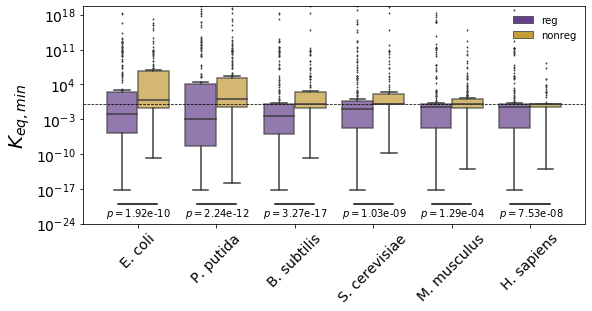

In [277]:
fig,ax = plt.subplots(1,1,figsize=(9,4))

_= sns.boxplot(x = 'organism', y='kmin', hue = 'classification', data=maxes_toplot,
               ax = ax, fliersize = 1,  palette=["rebeccapurple", "goldenrod"], boxprops=dict(alpha=.7))

ax.axhline(1,linewidth=0.75,linestyle='--',color='k')
plt.yscale('log')
plt.ylim(10**(-24),10**19.7)

ax.tick_params(axis='y', which='major', labelsize=14)
ax.tick_params(axis='x', which='major', labelsize=14, rotation=45)

for i in range(0,len(pvals)):
    
    ax.plot([i-0.25,i+0.25],[10**(-20),10**(-20)],color='k')
    ax.text(i-0.4, 10**(-22.5),r"$p=$"+"{:1.2e}".format(pvals[i]))

ax.set_ylabel('$K_{eq, min}$',fontsize=20)
ax.set_xlabel(None)

ax.legend(frameon=False)

plt.savefig('Keqmin dists.png',bbox_inches='tight')
plt.savefig('Keqmin dists.pdf',bbox_inches='tight')

In [155]:
len(dfmaxes[(dfmaxes['organism']=='H. sapiens')&(dfmaxes['classification']=='nonreg')]['kmin'])

140

In [494]:
ec_geo = pd.DataFrame([(x[0], 'E. coli', 'reg') for x in ec_geos if x[1] == 'reg'], 
                       columns = ('geoK', 'organism', 'classification'))
ec_geo = ec_geo.append(pd.DataFrame([(x[0], 'E. coli', 'nonreg') for x in ec_geos if x[1] == 'nonreg'], 
                                    columns = ('geoK', 'organism', 'classification')))

pp_geo = pd.DataFrame([(x[0], 'P. putida', 'reg') for x in pp_geos if x[1] == 'reg'], 
                       columns = ('geoK', 'organism', 'classification'))
pp_geo = pp_geo.append(pd.DataFrame([(x[0], 'P. putida', 'nonreg') for x in pp_geos if x[1] == 'nonreg'], 
                                    columns = ('geoK', 'organism', 'classification')))

bs_geo = pd.DataFrame([(x[0], 'B. subtilis', 'reg') for x in bs_geos if x[1] == 'reg'], 
                       columns = ('geoK', 'organism', 'classification'))
bs_geo = bs_geo.append(pd.DataFrame([(x[0], 'B. subtilis', 'nonreg') for x in bs_geos if x[1] == 'nonreg'], 
                                    columns = ('geoK', 'organism', 'classification')))

sc_geo = pd.DataFrame([(x[0], 'S. cerevisiae', 'reg') for x in sc_geos if x[1] == 'reg'], 
                       columns = ('geoK', 'organism', 'classification'))
sc_geo = sc_geo.append(pd.DataFrame([(x[0], 'S. cerevisiae', 'nonreg') for x in sc_geos if x[1] == 'nonreg'], 
                                    columns = ('geoK', 'organism', 'classification')))

mm_geo = pd.DataFrame([(x[0], 'M. musculus', 'reg') for x in mm_geos if x[1] == 'reg'], 
                       columns = ('geoK', 'organism', 'classification'))
mm_geo = mm_geo.append(pd.DataFrame([(x[0], 'M. musculus', 'nonreg') for x in mm_geos if x[1] == 'nonreg'], 
                                    columns = ('geoK', 'organism', 'classification')))

hs_geo = pd.DataFrame([(x[0], 'H. sapiens', 'reg') for x in hs_geos if x[1] == 'reg'], 
                       columns = ('geoK', 'organism', 'classification'))
hs_geo = hs_geo.append(pd.DataFrame([(x[0], 'H. sapiens', 'nonreg') for x in hs_geos if x[1] == 'nonreg'], 
                                    columns = ('geoK', 'organism', 'classification')))

df_geo = ec_geo.append(pp_geo).append(bs_geo).append(sc_geo).append(mm_geo).append(hs_geo)
df_geo

,geoK,organism,classification
0,2.238401e+10,E. coli,reg
1,NaN,E. coli,reg
2,5.598308e-15,E. coli,reg
3,1.868640e+02,E. coli,reg
4,2.701247e-03,E. coli,reg
...,...,...,...
391,NaN,H. sapiens,nonreg
392,9.728270e+04,H. sapiens,nonreg
393,NaN,H. sapiens,nonreg
394,NaN,H. sapiens,nonreg


In [495]:
df_geo.dropna(axis=0, inplace=True)
df_geo

,geoK,organism,classification
0,2.238401e+10,E. coli,reg
2,5.598308e-15,E. coli,reg
3,1.868640e+02,E. coli,reg
4,2.701247e-03,E. coli,reg
5,4.798550e+00,E. coli,reg
...,...,...,...
384,1.155908e-02,H. sapiens,nonreg
388,4.530761e-01,H. sapiens,nonreg
389,7.469324e+00,H. sapiens,nonreg
390,3.052266e+07,H. sapiens,nonreg


In [507]:
len(df_geo[(df_geo['organism']=='E. coli')&(df_geo['classification']=='nonreg')]['geoK'])

164

In [515]:
geo_toplot = df_geo[(df_geo['geoK'] >= 10**(-20))&(df_geo['geoK'] <= 10**19)]

pvals_all = []

for org in ['E. coli', 'P. putida', 'B. subtilis', 'S. cerevisiae', 'M. musculus', 'H. sapiens']:
    pval = scipy.stats.mannwhitneyu(df_geo[(df_geo['organism']==org)&(df_geo['classification']=='reg')]['geoK'],
                                    df_geo[(df_geo['organism']==org)&(df_geo['classification']=='nonreg')]['geoK'],
                                   alternative='less').pvalue
    pvals_all.append(pval)

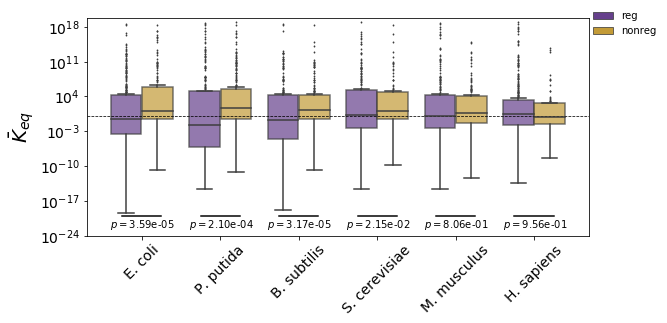

In [516]:
fig,ax = plt.subplots(1,1,figsize=(9,4))

_= sns.boxplot(x = 'organism', y='geoK', hue = 'classification', data=geo_toplot,
               ax = ax, fliersize = 1,  palette=["rebeccapurple", "goldenrod"], boxprops=dict(alpha=.7))

ax.axhline(1,linewidth=0.75,linestyle='--',color='k')
plt.yscale('log')
plt.ylim(10**(-24),10**19.7)

ax.tick_params(axis='y', which='major', labelsize=14)
ax.tick_params(axis='x', which='major', labelsize=14, rotation=45)

for i in range(0,len(pvals)):
    
    ax.plot([i-0.25,i+0.25],[10**(-20),10**(-20)],color='k')
    ax.text(i-0.4, 10**(-22.5),r"$p=$"+"{:1.2e}".format(pvals_all[i]))

ax.set_ylabel(r'$\bar{K}_{eq}$',fontsize=20)
ax.set_xlabel(None)

ax.legend(loc = (1,0.9),frameon=False)

#plt.savefig('Keq dists.png',bbox_inches='tight')
#plt.savefig('Keq dists.pdf',bbox_inches='tight')

### C.2 Metabolomics analysis
Previously-collected metabolomic data for up to 14 different carbon sources is analyzed to calculate distance from equilibrium in real metabolic steady states. See the main text for a description of data sources. Collated data is available in linked files.

In [579]:
# For visualization of K_eq-r relationship. Captures an envelope around all K_eq-r curves 

def get_envelope(data_gamma, data_r):
    
    n1 = np.linspace(0,0.05,10)
    n2 = np.linspace(0.3,0.8,25)
    n3 = np.linspace(0.9,1,25)

    intervals = np.linspace(0,5, 100)#np.concatenate((n1,n2,n3))

    maxr = []
    minr = []

    for i in range(0, len(intervals)-1):
        start = intervals[i]
        end = intervals[i+1]
    
        gamma_indices = np.where(np.logical_and(data_gamma > start, data_gamma <= end))
    
        rvals = []
    
        if len(gamma_indices[0]) == 0:
            continue
        else:
            for j in range(0,len(gamma_indices[0])-1):
            
                rvals.append(data_r[gamma_indices[0][j], gamma_indices[1][j]])
    
        if len(rvals) == 0:
            continue
        else:
            tempmax = max(rvals)
            tempmin = min(rvals)
    
            max_index = np.where(data_r == tempmax)
            min_index = np.where(data_r == tempmin)
    
            maxgamma = data_gamma[max_index[0][0],max_index[1][0]]
            mingamma = data_gamma[min_index[0][0],min_index[1][0]]
    
            maxr.append((maxgamma, tempmax))
            minr.append((mingamma, tempmin))
            
    return maxr, minr

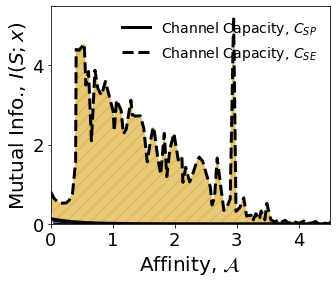

In [287]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3

x1 = [x[0] for x in maxr]
y1 = [x[1] for x in maxr]
x2 = [x[0] for x in minr]
y2 = [x[1] for x in minr]

x1r = [x[0] for x in maxrreg]
y1r = [x[1] for x in maxrreg]
x2r = [x[0] for x in minrreg]
y2r = [x[1] for x in minrreg]

ax.plot(x1,y1,color='k',alpha=1,linewidth=width, label=r'Channel Capacity, $C_{SP}$')
ax.plot(x1r,y1r,color='k',alpha=1,
        linewidth=width, linestyle = '--', label=r'Channel Capacity, $C_{SE}$')

ax.plot(x2,y2,color='k',alpha=1,linewidth=0.33*width)
ax.plot(x2r,y2r,color='k',alpha=1,linewidth=0.33*width)

ax.fill(
    np.append(x1r, x2r[::-1]),
    np.append(y1r, y2r[::-1]),
    color = 'goldenrod',
    alpha = 0.6,
    hatch = '//')

ax.fill(
    np.append(x1, x2[::-1]),
    np.append(y1, y2[::-1]),
    color = 'rebeccapurple',
    alpha = 0.6,
    hatch = '//')


ax.set_xlim(-0,4.5)
ax.set_ylim(0,)

ax.set_xlabel(r'Affinity, $\mathcal{A}$', fontsize=20)
ax.set_ylabel(r'Mutual Info., $I(S;x)$', fontsize=20)

ax.legend(frameon=False, loc='best', fontsize=14)

plt.locator_params(axis='both', nbins=5) 

ax.tick_params(axis='both', labelsize=18)

#plt.savefig('regcaps.png',bbox_inches='tight')
#plt.savefig('regcaps.pdf', bbox_inches='tight')

In [ ]:
maxr_e05, minr_e05 = get_envelope(data_a_e05, data_e05)
maxrreg_e05, minrreg_e05 = get_envelope(data_a_e05, data_reg_e05)

maxr, minr = get_envelope(data_a, data)
maxrreg, minrreg = get_envelope(data_a, data_reg)

maxr_e2, minr_e2 = get_envelope(data_a_e2, data_e2)
maxrreg_e2, minrreg_e2 = get_envelope(data_a_e2, data_reg_e2)

x1_e05 = [x[0] for x in maxrreg_e05]
y1_e05 = [x[1] for x in maxrreg_e05]
x2_e05 = [x[0] for x in minrreg_e05]
y2_e05 = [x[1] for x in minrreg_e05]

x1 = [x[0] for x in maxrreg]
y1 = [x[1] for x in maxrreg]
x2 = [x[0] for x in minrreg]
y2 = [x[1] for x in minrreg]

x1_e2 = [x[0] for x in maxrreg_e2]
y1_e2 = [x[1] for x in maxrreg_e2]
x2_e2 = [x[0] for x in minrreg_e2]
y2_e2 = [x[1] for x in minrreg_e2]

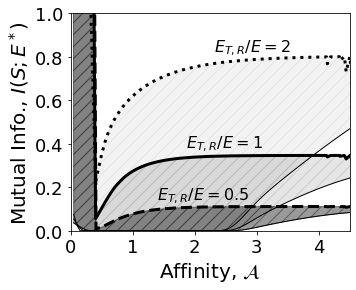

In [112]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3

ax.plot(x1_e05,y1_e05,color='k',alpha=1,linewidth=width, linestyle = '--', label=r'')
ax.plot(x1,y1,color='k',alpha=1, linewidth=width, linestyle = '-', label=r'$E_T/E = 1$')
ax.plot(x1_e2,y1_e2,color='k',alpha=1, linewidth=width, linestyle = ':', label=r'$E_T/E = 2$')

ax.plot(x2_e05,y2_e05,color='k',alpha=1,linewidth=0.33*width, linestyle = '-')
ax.plot(x2,y2,color='k',alpha=1, linewidth=0.33*width, linestyle = '-')
ax.plot(x2_e2,y2_e2,color='k',alpha=1, linewidth=0.33*width, linestyle = '-')

ax.fill(
    np.append(x1_e05, x2_e05[::-1]),
    np.append(y1_e05, y2_e05[::-1]),
    color = 'k',
    alpha = 0.4,
    hatch = '//')

ax.fill(
    np.append(x1, x2[::-1]),
    np.append(y1, y2[::-1]),
    color = 'k',
    alpha = 0.1,
    hatch = '//')

ax.fill(
    np.append(x1_e2, x2_e2[::-1]),
    np.append(y1_e2, y2_e2[::-1]),
    color = 'k',
    alpha = 0.05,
    hatch = '//')


ax.set_xlim(-0,4.5)
ax.set_ylim(0,1)

ax.set_xlabel(r'Affinity, $\mathcal{A}$', fontsize=20)
ax.set_ylabel(r'Mutual Info., $I(S;E^*)$', fontsize=20)

ax.annotate(r'$E_{T,R}/E = 2$',xy=(0.6, 0.82), xycoords='figure fraction', rotation = 0, fontsize=16)
ax.annotate(r'$E_{T,R}/E = 1$',xy=(0.52, 0.49), xycoords='figure fraction', rotation = 0, fontsize=16)
ax.annotate(r'$E_{T,R}/E = 0.5$',xy=(0.44, 0.31), xycoords='figure fraction', rotation = 0, fontsize=16)

#ax.legend(frameon=False, loc='best', fontsize=14)

plt.locator_params(axis='both', nbins=5) 

ax.tick_params(axis='both', labelsize=18)

plt.savefig('regcaps.png',bbox_inches='tight')
plt.savefig('regcaps.pdf', bbox_inches='tight')

In [106]:
x1c_e05 = [x[0] for x in maxr_e05]
y1c_e05 = [x[1] for x in maxr_e05]
x2c_e05 = [x[0] for x in minr_e05]
y2c_e05 = [x[1] for x in minr_e05]

x1c = [x[0] for x in maxr]
y1c = [x[1] for x in maxr]
x2c = [x[0] for x in minr]
y2c = [x[1] for x in minr]

x1c_e2 = [x[0] for x in maxr_e2]
y1c_e2 = [x[1] for x in maxr_e2]
x2c_e2 = [x[0] for x in minr_e2]
y2c_e2 = [x[1] for x in minr_e2]

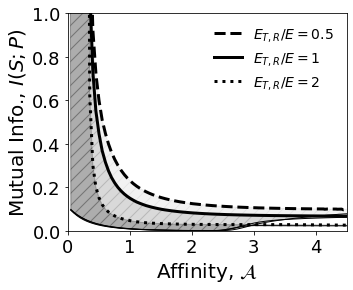

In [113]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3

ax.plot(x1c_e05,y1c_e05,color='k',alpha=1,linewidth=width, linestyle = '--', label=r'$E_{T,R}/E=0.5$')
ax.plot(x1c,y1c,color='k',alpha=1, linewidth=width, linestyle = '-', label=r'$E_{T,R}/E = 1$')
ax.plot(x1c_e2,y1c_e2,color='k',alpha=1, linewidth=width, linestyle = ':', label=r'$E_{T,R}/E = 2$')

ax.plot(x2c_e05,y2c_e05,color='k',alpha=1,linewidth=0.33*width, linestyle = '-')
ax.plot(x2c,y2c,color='k',alpha=1, linewidth=0.33*width, linestyle = '-')
ax.plot(x2c_e2,y2c_e2,color='k',alpha=1, linewidth=0.33*width, linestyle = '-')

ax.fill(
    np.append(x1c_e05, x2c_e05[::-1]),
    np.append(y1c_e05, y2c_e05[::-1]),
    color = 'k',
    alpha = 0.05,
    hatch = '//')

ax.fill(
    np.append(x1c, x2c[::-1]),
    np.append(y1c, y2c[::-1]),
    color = 'k',
    alpha = 0.1,
    hatch = '//')

ax.fill(
    np.append(x1c_e2, x2c_e2[::-1]),
    np.append(y1c_e2, y2c_e2[::-1]),
    color = 'k',
    alpha = 0.2,
    hatch = '//')


ax.set_xlim(-0,4.5)
ax.set_ylim(0,1)

ax.set_xlabel(r'Affinity, $\mathcal{A}$', fontsize=20)
ax.set_ylabel(r'Mutual Info., $I(S;P)$', fontsize=20)

#ax.annotate(r'$E_T/E = 2$',xy=(0.6, 0.82), xycoords='figure fraction', rotation = 0, fontsize=16)
#ax.annotate(r'$E_T/E = 1$',xy=(0.52, 0.48), xycoords='figure fraction', rotation = 0, fontsize=16)
#ax.annotate(r'$E_T/E = 0.5$',xy=(0.44, 0.31), xycoords='figure fraction', rotation = 0, fontsize=16)

ax.legend(frameon=False, loc='best', fontsize=14)

plt.locator_params(axis='both', nbins=5) 

ax.tick_params(axis='both', labelsize=18)

plt.savefig('catcaps.png',bbox_inches='tight')
plt.savefig('catcaps.pdf', bbox_inches='tight')

In [143]:
fluxes = np.linspace(0.01,0.99,1000)
krs = np.linspace(0.1, 10, 1000)

k = 1
krf = 1
krr = 1
kf = 1
Ks = 1
Et = 1
n = 2

data = np.zeros((1000,1000),dtype=float)
data_reg = np.zeros((1000,1000),dtype=float)
data_a = np.zeros((1000,1000),dtype=float)
data_ent = np.zeros((1000,1000),dtype=float)

for i in range(0,999): # For a given equilibrium constant
    for j in range(0,999): # Across all possible fluxes
        affinity, C = system_regn(fluxes[j], k, kf, krs[i], krf, krr, Et, Ks, n) #u, k, kf, kr, krf, krr, Et, Ks
        
        if affinity < 0:
            continue
        else:
            corr = C[1]/(np.sqrt(C[0]*C[4]))
            corr_reg = C[2]/(np.sqrt(C[0]*C[-1]))
            

            data[i][j] = -0.5*np.log(1-corr**2)
            data_reg[i][j] = -0.5*np.log(1-corr_reg**2)
            data_ent[i][j] = 0.5*np.log(2*pi*e*C[0])
            data_a[i][j] = affinity

C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:24 RuntimeWarning: invalid value encountered in sqrt
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:25 RuntimeWarning: invalid value encountered in sqrt
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:30 RuntimeWarning: invalid value encountered in log
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:29 RuntimeWarning: invalid value encountered in log


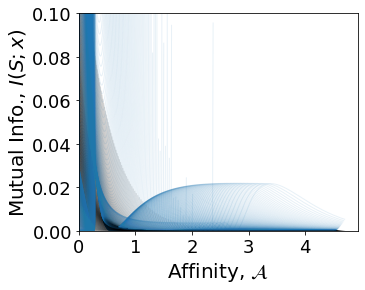

In [145]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 1

for i in range(0,700):
    ax.plot(data_a[i][:-1], data[i][:-1],color='k',alpha=0.1,linewidth=width)
    ax.plot(data_a[i][:-1], data_reg[i][:-1],color='C00000',alpha=0.1,linewidth=width)
    #ax.plot(data_a[i][:-1], data_ent[i][:-1], color='C00001')

ax.set_xlim(0,)
ax.set_ylim(0,0.1)

ax.set_xlabel(r'Affinity, $\mathcal{A}$', fontsize=20)
ax.set_ylabel(r'Mutual Info., $I(S;x)$', fontsize=20)

plt.locator_params(axis='both', nbins=5) 

ax.tick_params(axis='both', labelsize=18)

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3

x1 = [x[0] for x in maxr]
y1 = [x[1] for x in maxr]
x2 = [x[0] for x in minr]
y2 = [x[1] for x in minr]

x1r = [x[0] for x in maxrreg]
y1r = [x[1] for x in maxrreg]
x2r = [x[0] for x in minrreg]
y2r = [x[1] for x in minrreg]

ax.plot(x1,y1,color='k',alpha=1,linewidth=width, label=r'Channel Capacity, $C_{SP}$')
ax.plot(x1_e2,y1_e2,color='k',alpha=1,
        linewidth=width, linestyle = '--', label=r'Channel Capacity, $C_{SE}$')

ax.plot(x2,y2,color='k',alpha=1,linewidth=0.33*width)
ax.plot(x2r,y2r,color='k',alpha=1,linewidth=0.33*width)

ax.fill(
    np.append(x1r, x2r[::-1]),
    np.append(y1r, y2r[::-1]),
    color = 'goldenrod',
    alpha = 0.6,
    hatch = '//')

ax.fill(
    np.append(x1, x2[::-1]),
    np.append(y1, y2[::-1]),
    color = 'rebeccapurple',
    alpha = 0.6,
    hatch = '//')


ax.set_xlim(-0,4.5)
ax.set_ylim(0,1)

ax.set_xlabel(r'Affinity, $\mathcal{A}$', fontsize=20)
ax.set_ylabel(r'Mutual Info., $I(S;x)$', fontsize=20)

ax.legend(frameon=False, loc='best', fontsize=14)

plt.locator_params(axis='both', nbins=5) 

ax.tick_params(axis='both', labelsize=18)

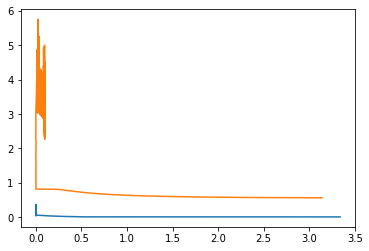

In [242]:
caps = []
affs = []

caps_reg = []
affs_reg = []

for i in range(0,700):
    caps.append(data[i][np.where(data[i] == max(data[i]))][0])
    affs.append(data_a[i][np.where(data[i] == max(data[i]))][0])
    
    caps_reg.append(data_reg[i][np.where(data_reg[i] == max(data_reg[i]))][0])
    affs_reg.append(data_a[i][np.where(data_reg[i] == max(data_reg[i]))][0])

plt.plot(affs,caps)    
plt.plot(affs_reg,caps_reg)

#plt.ylim(0,1)

In [185]:
data_reg[100][np.where(data_reg[100] == max(data_reg[100]))][0]

0.30748680655099836

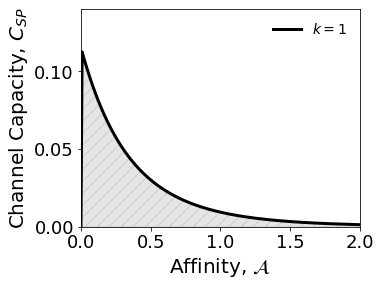

In [166]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3

ax.plot(data_a[:,0][0:700], data[:,0][0:700],color='k',alpha=1,linewidth=width, label=r'$k=1$')
#ax.plot(data_a5[:,0][:505], data5[:,0][:505],color='k',alpha=1,linewidth=width, linestyle = '--', label=r'$k=5$')

plt.fill_between(
        x= data_a[:,0][0:93], 
        y1= data[:,0][0:93],
        color= "k",
        hatch = '//',
        alpha= 0.1)



ax.set_xlim(-0,2)
ax.set_ylim(0,0.14)

ax.set_xlabel(r'Affinity, $\mathcal{A}$', fontsize=20)
ax.set_ylabel(r'Channel Capacity, $C_{SP}$', fontsize=20)

ax.legend(frameon=False, loc='best', fontsize=14)

plt.locator_params(axis='both', nbins=5) 

ax.tick_params(axis='both', labelsize=18)

Break

In [16]:
# Calculates the Jacobian and diagonal rate equation matrices

def matrices(Ks, Kp, kf, kr, u, S, P, E, k):
    
    Keq = (kf/Ks)/(kr/Kp)
    
    dfdS = kf*E/Ks*((1+1/Kp*(P+kf/kr))/(1+S/Ks+P/Kp)**2)
    dfdP = kf*E/Ks*(((P-S)/Kp-(1+S/Ks+P/Kp)/(Keq))/(1+S/Ks+P/Kp)**2)
    
    A = np.array([[-dfdS,-dfdP],
                 [dfdS, dfdP-k]])
    
    v = kf*E*(S/Ks)/(1+S/Ks+P/Kp)*(1-(P/S)/Keq)
    
    f = np.array([[u, 0, 0],
                 [0, v, 0],
                 [0, 0, k*P]])
    
    return A, f

In [17]:
# Defines a new matrix, equivalent to A' above, based on the system structure. This is used to solve the fluctuation-dissipation
# balance for the covariance matrix, C

def findC(S, A, f):
    
    BB_T = np.matmul(S,f)
    BB_T = np.matmul(BB_T, S.T)
    BB_T = BB_T.flatten()
    
    ACCAT = np.array([[2*A[0,0], A[0,1], A[0,1],0],
                     [A[1,0], A[0,0]+A[1,1], 0, A[0,1]],
                     [A[1,0], 0, A[0,0]+A[1,1], A[0,1]],
                     [0, A[1,0], A[1,0], 2*A[1,1]]])
    
    C = np.linalg.solve(ACCAT,-BB_T)
    
    return C, BB_T, ACCAT

### A.2 Find cross-correlations for varied thermodynamic parameter and other parameters
The system is integrated to steady-state for a given parameter set across a range of $K_{eq}$ values. This is achieved by adjusting the favourability of the reverse reaction, $k_{cat}^-$. A nominal parameter set is initially used, followed by adjustment of the catalyzing enzyme pool, $E$, and the rate at which $P$ leaves the system, $k_o$.

Note that initially $\Gamma = \frac{\tilde{P}}{\tilde{S}}$ was used for visualization. This was changed to $\Delta = 1-\Gamma$ in the final manuscript. Variable names in this notebook reflect the initial approach.

In [96]:
# Define a nominal parameter set, then integrate the system to steady-state for LNA.

Ks = 0.1
Kp = 0.1

kf = 1

ko = 1 # Defines how quickly the product, P, leaves the system
E = 1

S = np.array([[1, -1, 0],
              [0, 1, -1]]) # Stoichiometric matrix

fluxes = np.linspace(0,0.99,100)
krs = np.linspace(0.1,10,100)

data_r = np.zeros((100,100),dtype=float) # Array for cross-correlation values
data_gamma = np.zeros((100,100),dtype=float) # Array for distance from equilibrium

n = 100
t = np.linspace(0,10000,n)

x0 = [0.01, 0] #S_0 set to a small, non-zero value to avoid numerical issues

# Integrate across influxes and K_eq values

for i in range(0,99):
    for j in range(0,99):
        Keq = (kf/Ks)/(krs[i]/Kp)
        
        k = np.array([E, kf, krs[i], Ks, Kp, fluxes[j], ko])
    
        y = odeint(system, x0, t, args = (k,))
    
        A, f = matrices(Ks, Kp, kf, krs[i], fluxes[j], y[-1][0], y[-1][1], E, ko)
    
        C, BB_T, ACCAT = findC(S,A,f)
    
        r = -0.5*np.log(1-(C[1]**2/(C[0]*C[3])))
        gamma = (y[-1][1]/y[-1][0])/Keq
        
        data_r[i][j] = r
        data_gamma[i][j] = -np.log(gamma)

C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:39 RuntimeWarning: invalid value encountered in log
C:\Users\euler\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248 ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


In [25]:
# As above, but with an adjusted k_o value

Ks = 0.1
Kp = 0.1

kf = 1

ko = 10
E = 1

S = np.array([[1, -1, 0],
              [0, 1, -1]])

fluxes = np.linspace(0,0.99,100)
krs = np.linspace(0.1,10,100)

data_r10 = np.zeros((100,100),dtype=float)
data_gamma10 = np.zeros((100,100),dtype=float)

n = 100
t = np.linspace(0,10000,n)

x0 = [0.01, 0]

for i in range(0,99):
    for j in range(0,99):
        Keq = (kf/Ks)/(krs[i]/Kp)
        
        k = np.array([E, kf, krs[i], Ks, Kp, fluxes[j], ko])
    
        y = odeint(system, x0, t, args = (k,))
    
        A, f = matrices(Ks, Kp, kf, krs[i], fluxes[j], y[-1][0], y[-1][1], E, ko)
    
        C, BB_T, ACCAT = findC(S,A,f)
    
        r = -0.5*np.log(1-(C[1]**2/(C[0]*C[3])))
        gamma = (y[-1][1]/y[-1][0])/Keq
        
        data_r10[i][j] = r
        data_gamma10[i][j] = -np.log(gamma)

C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:41 RuntimeWarning: invalid value encountered in log
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:37 RuntimeWarning: invalid value encountered in log


In [26]:
# As above, but with an adjusted E value

Ks = 0.1
Kp = 0.1

kf = 1

ko = 1
E = 10

S = np.array([[1, -1, 0],
              [0, 1, -1]])

fluxes = np.linspace(0,0.99,100)
krs = np.linspace(0.1,10,100)

data_rE = np.zeros((100,100),dtype=float)
data_gammaE = np.zeros((100,100),dtype=float)

n = 100
t = np.linspace(0,10000,n)

x0 = [0.01, 0]

for i in range(0,99):
    for j in range(0,99):
        Keq = (kf/Ks)/(krs[i]/Kp)
        
        k = np.array([E, kf, krs[i], Ks, Kp, fluxes[j], ko])
    
        y = odeint(system, x0, t, args = (k,))
    
        A, f = matrices(Ks, Kp, kf, krs[i], fluxes[j], y[-1][0], y[-1][1], E, ko)
    
        C, BB_T, ACCAT = findC(S,A,f)
    
        r = -0.5*np.log(1-(C[1]**2/(C[0]*C[3])))
        gamma = (y[-1][1]/y[-1][0])/Keq
        
        data_rE[i][j] = r
        data_gammaE[i][j] = -np.log(gamma)

C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:37 RuntimeWarning: invalid value encountered in log


Text(0, 0.5, 'Mutual Info., $I(S;P)$')

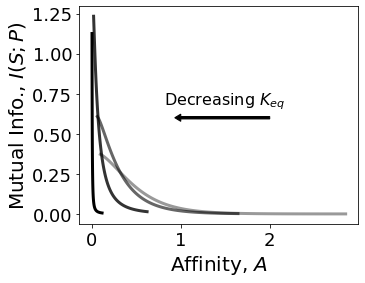

In [121]:
# Plot r as a function of distance from equilibrium for a few K_eq values for the nominal parameter set case

fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3

ax.plot(data_gamma[10][1:-1], data_r[10][1:-1],color='k',alpha=0.4,linewidth=width)
ax.plot(data_gamma[13][1:-1], data_r[13][1:-1],color='k',alpha=0.6,linewidth=width)
ax.plot(data_gamma[25][1:-1], data_r[25][1:-1],color='k',alpha=0.8,linewidth=width)
ax.plot(data_gamma[98][1:-1], data_r[98][1:-1],color='k',alpha=1,linewidth=width)

#ax.set_xlim(0,)
#ax.set_ylim(-0.05,1.0)

ax.tick_params(axis='both', labelsize=18)

ax.annotate(r'Decreasing $K_{eq}$',xy=(0.45, 0.63), xycoords='figure fraction', rotation = 0, fontsize=16)

ax.arrow(2,0.6,-1,0,width=0.015,color='k')

ax.set_xlabel(r'Affinity, $A$', fontsize=20)
ax.set_ylabel(r'Mutual Info., $I(S;P)$', fontsize=20)

#ax.set_xscale('log')

#plt.savefig('rsp-gamma.pdf',bbox_inches='tight')
#plt.savefig('rsp-gamma.png',bbox_inches='tight')

In [122]:
# Generate envelopes for all parameter sets

maxr,minr = get_envelope(data_gamma[:,1:-1], data_r[:,1:-1]) 
maxr10,minr10 = get_envelope(data_gamma10[:,1:-1], data_r10[:,1:-1])
maxrE,minrE = get_envelope(data_gammaE[:,1:-1], data_rE[:,1:-1])

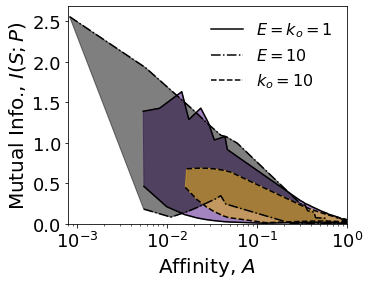

In [123]:
# Plot those envelopes

fig, ax = plt.subplots(1,1,figsize=(5,4))

x1 = np.array([x[0] for x in maxr])
x2 = np.array([x[0] for x in minr])
y1 = np.array([x[1] for x in maxr])
y2 = np.array([x[1] for x in minr])
ax.plot(x1,y1,color='k')
ax.plot(x2,y2, color = 'k', label = r'$E=k_o=1$')

ax.fill(
    np.append(x1, x2[::-1]),
    np.append(y1, y2[::-1]),
    color = 'rebeccapurple', alpha = 0.6)

x1E = np.array([x[0] for x in maxrE])
x2E = np.array([x[0] for x in minrE])
y1E = np.array([x[1] for x in maxrE])
y2E = np.array([x[1] for x in minrE])
ax.plot(x1E,y1E,color='k',linestyle='-.')
ax.plot(x2E,y2E, color = 'k',linestyle = '-.', label = r'$E=10$')

ax.fill(
    np.append(x1E, x2E[::-1]),
    np.append(y1E, y2E[::-1]),
    color = 'k', alpha = 0.5)

x110 = np.array([x[0] for x in maxr10])
x210 = np.array([x[0] for x in minr10])
y110 = np.array([x[1] for x in maxr10])
y210 = np.array([x[1] for x in minr10])
ax.plot(x110,y110,color='k',linestyle='--')
ax.plot(x210,y210, color = 'k',linestyle = '--', label='$k_o = 10$')

ax.fill(
    np.append(x110, x210[::-1]),
    np.append(y110, y210[::-1]),
    color = 'goldenrod', alpha = 0.6)

ax.set_xlim(10**(-3.1),1.0)
ax.set_ylim(0,)
ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon = False, loc = 'best',fontsize=16)

ax.set_xlabel(r'Affinity, $A$', fontsize=20)
ax.set_ylabel(r'Mutual Info., $I(S;P)$', fontsize=20)
ax.set_xscale('log')

#plt.savefig('envelope.pdf',bbox_inches='tight')
#plt.savefig('envelope.png',bbox_inches='tight')

In [124]:
# Define the rate equations for the system which includes the regulated enzyem

def system_reg(x,t,k):
    
    Keq = (k[1]/k[3])/(k[2]/k[4])
    
    dSdt = k[5] - k[0]*k[2]*x[0]/k[3]/(1+x[0]/k[3]+x[1]/k[4])*(1-(x[1]/x[0])/Keq) + k[8]*x[2] - k[7]*(10-x[2])*x[0] 
    dPdt = k[0]*k[2]*x[0]/k[3]/(1+x[0]/k[3]+x[1]/k[4])*(1-(x[1]/x[0])/Keq) - k[6]*x[1]
    dESdt = -k[8]*x[2] + k[7]*(10-x[2])*x[0]
    
    return [dSdt, dPdt, dESdt]

In [125]:
# As above, define a function which calculates the Jacobian and diagonal rate matrices

def matrices_reg(Ks, Kp, kf, kr, u, S, P, ES, E, k, kIf, kIr):
    
    Keq = (kf/Ks)/(kr/Kp)
    
    dfdS = kf*E/Ks*((1+1/Kp*(P+kf/kr))/(1+S/Ks+P/Kp)**2)
    dfdP = kf*E/Ks*(((P-S)/Kp-(1+S/Ks+P/Kp)/(Keq))/(1+S/Ks+P/Kp)**2)
    
    A = np.array([[-dfdS - kIf*(10-ES), -dfdP, kIr+kIf*S],
                 [dfdS, dfdP-k, 0],
                 [kIf*(10-ES), 0, -kIf*S-kIr]])
    
    v = kf*E*(S/Ks)/(1+S/Ks+P/Kp)*(1-(P/S)/Keq)
    
    f = np.array([[u, 0, 0, 0, 0],
                  [0, v, 0, 0, 0],
                  [0, 0, kIr*ES, 0, 0],
                  [0, 0, 0, kIf*(10-ES)*S, 0],
                  [0, 0, 0, 0, k*P]])
    
    return A, f

In [126]:
# As above, define a function to find the covariance matrix using A'

def findC_reg(S, A, f):
    
    BB_T = np.matmul(S,f)
    BB_T = np.matmul(BB_T, S.T)
    BB_T = BB_T.flatten()
    
    ACCAT = np.array([[2*A[0,0], A[0,1], A[0,2], A[0,1], 0, 0, A[0,2], 0, 0],
                     [A[1,0], A[0,0] + A[1,1], A[1,2], 0, A[0,1], 0, 0, A[0,2], 0],
                     [A[2,0], A[2,1], A[0,0] + A[2,2], 0, 0, A[0,1], 0, 0, A[0,2]],
                     [A[1,0], 0, 0, A[0,0] + A[1,1], A[0,1], A[0,2], A[1,2], 0, 0],
                     [0, A[1,0], 0, A[1,0], 2*A[1,1], A[2,2], 0, A[1,2], 0],
                     [0, 0, A[1,0], A[2,0], A[2,1], A[1,1] + A[2,2], 0, 0, A[1,2]],
                     [A[2,0], 0, 0, A[2,1], 0, 0, A[2,2] + A[0,0], A[0,1], A[0,2]],
                     [0, A[2,0], 0, 0, A[2,1], 0, A[1,0], A[2,2] + A[1,1], A[1,2]],
                     [0, 0, A[2,0], 0, 0, A[2,2], A[2,0], A[2,1], 2*A[2,2]]])
    
    C = np.linalg.solve(ACCAT,-BB_T)
    
    return C, BB_T, ACCAT

In [135]:
# As above, integrate the system to steady-state across a range of influxes and K_eq values

Ks = 0.1
Kp = 0.1

kf = 1

kIf = 0.01 # Rate parameter for binding of S to E
kIr = 1 # Rate parameter for unbinding of S from E*

ko = 1.5
E = 1

S_reg = np.array([[1, -1, 1, -1, 0],
                  [0, 1, 0, 0, -1],
                  [0, 0, -1, 1, 0]]) # Stoichiometric matrix update to include S-E binding

fluxes = np.linspace(0,0.99,100)
krs = np.linspace(0.1,10,100)

data_rcat = np.zeros((100,100),dtype=float) # Array for storing cross-correlation values between S and P ("catalytic")
data_rreg = np.zeros((100,100),dtype=float) # Array for storing cross-correlation values between S and E ("regulatory")
data_gammareg = np.zeros((100,100),dtype=float)

n = 100
t = np.linspace(0,10000,n)

x0 = [0.01, 0, 0]

for i in range(0,99):
    for j in range(0,99):
        Keq = (kf/Ks)/(krs[i]/Kp)
        
        k = np.array([E, kf, krs[i], Ks, Kp, fluxes[j], ko, kIf, kIr])
    
        y = odeint(system_reg, x0, t, args = (k,))
    
        A, f = matrices_reg(Ks, Kp, kf, krs[i], fluxes[j], y[-1][0], y[-1][1], y[-1][2], E, ko, kIf, kIr)
        
        C, BB_T, ACCAT = findC_reg(S_reg,A,f)
    
        r = C[1]/np.sqrt((C[0]*C[4]))
        r_reg = C[2]/np.sqrt((C[0]*C[-1]))
        gamma = (y[-1][1]/y[-1][0])/Keq
        
        data_rcat[i][j] = r
        data_rreg[i][j] = r_reg
        data_gammareg[i][j] = gamma

C:\Users\euler\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248 ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:43 RuntimeWarning: invalid value encountered in sqrt


Text(0, 0.5, 'Mutual Info., $I(S;X)$')

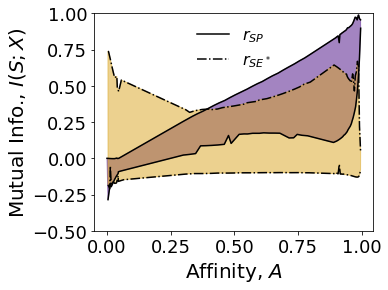

In [145]:
# Visualize the r-K_eq envelopes for the regulated case

maxrinh,minrinh = get_envelope(data_gammareg[:,1:-1], data_rreg[:,1:-1])
maxr,minr = get_envelope(data_gammareg[:,1:-1], data_rcat[:,1:-1])

fig, ax = plt.subplots(1,1,figsize=(5,4))

x1 = np.array([x[0] for x in maxr])
x2 = np.array([x[0] for x in minr])
y1 = np.array([x[1] for x in maxr])
y2 = np.array([x[1] for x in minr])
ax.plot(x1,y1,color='k')
ax.plot(x2,y2, color = 'k', label = r'$r_{SP}$')

ax.fill(
    np.append(x1, x2[::-1]),
    np.append(y1, y2[::-1]),
    color = 'rebeccapurple', alpha = 0.6)

x1E = np.array([x[0] for x in maxrinh])
x2E = np.array([x[0] for x in minrinh])
y1E = np.array([x[1] for x in maxrinh])
y2E = np.array([x[1] for x in minrinh])
ax.plot(x1E,y1E,color='k',linestyle='-.')
ax.plot(x2E,y2E, color = 'k',linestyle = '-.', label = r'$r_{SE^*}$')

ax.fill(
    np.append(x1E, x2E[::-1]),
    np.append(y1E, y2E[::-1]),
    color = 'goldenrod', alpha = 0.5)

#ax.set_xlim(1.0,0)
#ax.set_xticklabels([1.0, 0.8,0.6,0.4,0.2,0.0])

ax.set_ylim(-0.5,1.0)
ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon = False, loc = 'best',fontsize=16)

ax.set_xlabel(r'Affinity, $A$', fontsize=20)
ax.set_ylabel(r'Mutual Info., $I(S;X)$', fontsize=20)

#plt.savefig('envelope.pdf',bbox_inches='tight')
#plt.savefig('envelope.png',bbox_inches='tight')

In the above analysis, the stoichiometry for regulation, $\eta=1$, is implied. Now consider the case in which $\eta =2$. This requires redefining the rate equations and matrices for LNA.

In [146]:
def system_reg2(x,t,k):
    
    Keq = (k[1]/k[3])/(k[2]/k[4])
    
    dSdt = k[5] - k[0]*k[2]*x[0]/k[3]/(1+x[0]/k[3]+x[1]/k[4])*(1-(x[1]/x[0])/Keq) + k[8]*x[2] - 2*k[7]*(10-x[2])*x[0]**2
    dPdt = k[0]*k[2]*x[0]/k[3]/(1+x[0]/k[3]+x[1]/k[4])*(1-(x[1]/x[0])/Keq) - k[6]*x[1]
    dESdt = -k[8]*x[2] + 2*k[7]*(10-x[2])*x[0]**2
    
    return [dSdt, dPdt, dESdt]

def matrices_reg2(Ks, Kp, kf, kr, u, S, P, ES, E, k, kIf, kIr):
    
    Keq = (kf/Ks)/(kr/Kp)
    
    dfdS = kf*E/Ks*((1+1/Kp*(P+kf/kr))/(1+S/Ks+P/Kp)**2)
    dfdP = kf*E/Ks*(((P-S)/Kp-(1+S/Ks+P/Kp)/(Keq))/(1+S/Ks+P/Kp)**2)
    
    A = np.array([[-dfdS - 4*kIf*S*(10-ES), -dfdP, kIr+2*kIf*S**2],
                 [dfdS, dfdP-k, 0],
                 [4*kIf*S*(10-ES), 0, -2*kIf*S**2-kIr]])
    
    v = kf*E*(S/Ks)/(1+S/Ks+P/Kp)*(1-(P/S)/Keq)
    
    f = np.array([[u, 0, 0, 0, 0],
                  [0, v, 0, 0, 0],
                  [0, 0, kIr*ES, 0, 0],
                  [0, 0, 0, kIf*(10-ES)*S**2, 0],
                  [0, 0, 0, 0, k*P]])
    
    return A, f

In [152]:
# As above, integrate with the nominal parameter set first

Ks = 0.1
Kp = 0.1

kf = 1

kIf = 0.01
kIr = 1

ko = 1.5
E = 1

S_reg2 = np.array([[1, -1, 1, -2, 0],
                  [0, 1, 0, 0, -1],
                  [0, 0, -1, 2, 0]])

fluxes = np.linspace(0,0.99,100)
krs = np.linspace(0.1,10,100)

data_rcat2_1 = np.zeros((100,100),dtype=float)
data_rreg2_1 = np.zeros((100,100),dtype=float)
data_gammareg2_1 = np.zeros((100,100),dtype=float)

n = 100
t = np.linspace(0,10000,n)

x0 = [0.01, 0, 0]

for i in range(0,99):
    for j in range(0,99):
        Keq = (kf/Ks)/(krs[i]/Kp)
        
        k = np.array([E, kf, krs[i], Ks, Kp, fluxes[j], ko, kIf, kIr])
    
        y = odeint(system_reg2, x0, t, args = (k,))
    
        A, f = matrices_reg2(Ks, Kp, kf, krs[i], fluxes[j], y[-1][0], y[-1][1], y[-1][2], E, ko, kIf, kIr)
        
        C, BB_T, ACCAT = findC_reg(S_reg2,A,f)
    
        r = C[1]/np.sqrt((C[0]*C[4]))
        r_reg = C[2]/np.sqrt((C[0]*C[-1]))
        gamma = (y[-1][1]/y[-1][0])/Keq
        
        data_rcat2_1[i][j] = r
        data_rreg2_1[i][j] = r_reg
        data_gammareg2_1[i][j] = gamma

C:\Users\euler\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248 ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:43 RuntimeWarning: invalid value encountered in sqrt


In [150]:
# Now, adjust k_o

Ks = 0.1
Kp = 0.1

kf = 1

kIf = 0.01
kIr = 1

ko = 10
E = 1

S_reg2 = np.array([[1, -1, 1, -2, 0],
                  [0, 1, 0, 0, -1],
                  [0, 0, -1, 2, 0]])

fluxes = np.linspace(0,0.99,100)
krs = np.linspace(0.1,10,100)

data_rcat2_10 = np.zeros((100,100),dtype=float)
data_rreg2_10 = np.zeros((100,100),dtype=float)
data_gammareg2_10 = np.zeros((100,100),dtype=float)

n = 100
t = np.linspace(0,10000,n)

x0 = [0.01, 0, 0]

for i in range(0,99):
    for j in range(0,99):
        Keq = (kf/Ks)/(krs[i]/Kp)
        
        k = np.array([E, kf, krs[i], Ks, Kp, fluxes[j], ko, kIf, kIr])
    
        y = odeint(system_reg2, x0, t, args = (k,))
    
        A, f = matrices_reg2(Ks, Kp, kf, krs[i], fluxes[j], y[-1][0], y[-1][1], y[-1][2], E, ko, kIf, kIr)
        
        C, BB_T, ACCAT = findC_reg(S_reg2,A,f)
    
        r = C[1]/np.sqrt((C[0]*C[4]))
        r_reg = C[2]/np.sqrt((C[0]*C[-1]))
        gamma = (y[-1][1]/y[-1][0])/Keq
        
        data_rcat2_10[i][j] = r
        data_rreg2_10[i][j] = r_reg
        data_gammareg2_10[i][j] = gamma

C:\Users\euler\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248 ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:43 RuntimeWarning: invalid value encountered in sqrt
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:42 RuntimeWarning: invalid value encountered in sqrt


Text(0, 0.5, 'Mutual Info., $I(S;X)$')

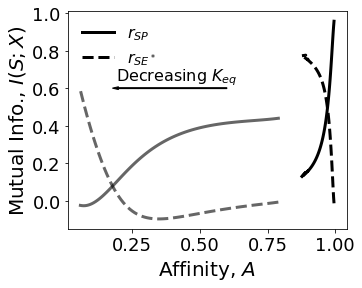

In [153]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3

ax.plot(data_gammareg2_1[7][1:-30], data_rcat2_1[7][1:-30],color='k',alpha=0.6, linewidth=width)
ax.plot(data_gammareg2_1[7][1:-30], data_rreg2_1[7][1:-30],color='k',alpha=0.6,linestyle='--',linewidth=width)

#ax.plot(data_gammainh2_1[20][1:-1], data_rcat2_1[20][1:-1],color='k',alpha=0.75)
#ax.plot(data_gammainh2_1[20][1:-1], data_rinh2_1[20][1:-1],color='k',alpha=0.75,linestyle='--')

ax.plot(data_gammareg2_1[70][1:-23], data_rcat2_1[70][1:-23],color='k',alpha=1,label=r'$r_{SP}$',linewidth=width)
ax.plot(data_gammareg2_1[70][1:-23], data_rreg2_1[70][1:-23],color='k',alpha=1,linestyle='--',label=r'$r_{SE^*}$',linewidth=width)

#ax.set_xlim(1.0,-0.001)
#ax.set_xticklabels([1.0, 0.8,0.6,0.4,0.2,0.0])
#ax.set_ylim(-0.15,1.0)

ax.annotate(r'Decreasing $K_{eq}$',xy=(0.32, 0.72), xycoords='figure fraction', rotation = 0, fontsize=16)

ax.arrow(0.6,0.6,-0.4,0,width=0.005,color='k')

ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon = False, loc = 'best',fontsize=16)

ax.set_xlabel(r'Affinity, $A$', fontsize=20)
ax.set_ylabel(r'Mutual Info., $I(S;X)$', fontsize=20)

#plt.savefig('res-gamma.pdf',bbox_inches='tight')
#plt.savefig('res-gamma.png',bbox_inches='tight')

Text(0, 0.5, 'Cross-Correlation, $r_{SE^*}$')

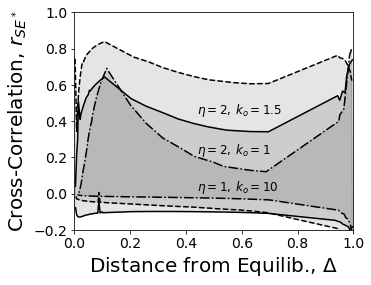

In [67]:
maxrreg,minrreg = get_envelope(data_gammareg[:,1:-1], data_rreg[:,1:-1])
maxr2_1,minr2_1 = get_envelope(data_gammareg2_1[:,1:-1], data_rreg2_1[:,1:-1])
maxr2_10,minr2_10 = get_envelope(data_gammareg2_10[:,1:-1], data_rreg2_10[:,1:-1])

fig, ax = plt.subplots(1,1,figsize=(5,4))

x1E = np.array([x[0] for x in maxrinh])
x2E = np.array([x[0] for x in minrinh])
y1E = np.array([x[1] for x in maxrinh])
y2E = np.array([x[1] for x in minrinh])
ax.plot(x1E,y1E,color='k',linestyle='-')
ax.plot(x2E,y2E, color = 'k',linestyle = '-', label = r'$\eta = 1, \, k_o=1$')

ax.fill(
    np.append(x1E, x2E[::-1]),
    np.append(y1E, y2E[::-1]),
    color = 'k', alpha = 0.1)

x1 = np.array([x[0] for x in maxr2_1])
x2 = np.array([x[0] for x in minr2_1])
y1 = np.array([x[1] for x in maxr2_1])
y2 = np.array([x[1] for x in minr2_1])
ax.plot(x1,y1,color='k',linestyle='--')
ax.plot(x2,y2, color = 'k', linestyle ='--', label = r'$\eta = 2, \, k_o=1$')

ax.fill(
    np.append(x1, x2[::-1]),
    np.append(y1, y2[::-1]),
    color = 'k', alpha = 0.1)

x1 = np.array([x[0] for x in maxr2_10])
x2 = np.array([x[0] for x in minr2_10])
y1 = np.array([x[1] for x in maxr2_10])
y2 = np.array([x[1] for x in minr2_10])
ax.plot(x1,y1,color='k',linestyle = '-.')
ax.plot(x2,y2, color = 'k', linestyle='-.', label = r'$\eta = 2, \, k_o=10$')

ax.fill(
    np.append(x1, x2[::-1]),
    np.append(y1, y2[::-1]),
    color = 'k', alpha = 0.1)

ax.set_xlim(1.0,0)
ax.set_xticklabels([1.0, 0.8,0.6,0.4,0.2,0.0])

ax.set_ylim(-0.2,1.0)
ax.tick_params(axis='both', labelsize=14)

#ax.legend(frameon = False, loc = (0.01,-0.03),fontsize=14)

ax.annotate(r'$\eta = 1, \, k_o=10$',xy=(0.53, 0.33), xycoords='figure fraction', rotation = 0, fontsize=12)
ax.annotate(r'$\eta = 2, \, k_o=1$',xy=(0.53, 0.46), xycoords='figure fraction', rotation = 0, fontsize=12)
ax.annotate(r'$\eta = 2, \, k_o=1.5$',xy=(0.53, 0.6), xycoords='figure fraction', rotation = 0, fontsize=12)

ax.set_xlabel(r'Distance from Equilib., $\Delta$', fontsize=20)
ax.set_ylabel(r'Cross-Correlation, $r_{SE^*}$', fontsize=20)

#plt.savefig('res envelope.pdf',bbox_inches='tight')
#plt.savefig('res envelope.png',bbox_inches='tight')

Text(0, 0.5, 'Cross-Correlation, $r$')

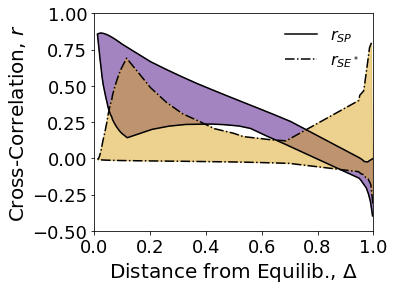

In [65]:
maxrreg,minrreg = get_envelope(data_gammareg2_10[:,1:-1], data_rreg2_10[:,1:-1])
maxr,minr = get_envelope(data_gammareg2_10[:,1:-1], data_rcat2_10[:,1:-1])

fig, ax = plt.subplots(1,1,figsize=(5,4))

x1 = np.array([x[0] for x in maxr])
x2 = np.array([x[0] for x in minr])
y1 = np.array([x[1] for x in maxr])
y2 = np.array([x[1] for x in minr])
ax.plot(x1,y1,color='k')
ax.plot(x2,y2, color = 'k', label = r'$r_{SP}$')

ax.fill(
    np.append(x1, x2[::-1]),
    np.append(y1, y2[::-1]),
    color = 'rebeccapurple', alpha = 0.6)

x1E = np.array([x[0] for x in maxrreg])
x2E = np.array([x[0] for x in minrreg])
y1E = np.array([x[1] for x in maxrreg])
y2E = np.array([x[1] for x in minrreg])
ax.plot(x1E,y1E,color='k',linestyle='-.')
ax.plot(x2E,y2E, color = 'k',linestyle = '-.', label = r'$r_{SE^*}$')

ax.fill(
    np.append(x1E, x2E[::-1]),
    np.append(y1E, y2E[::-1]),
    color = 'goldenrod', alpha = 0.5)

ax.set_xlim(1.0,0)
ax.set_ylim(-0.5,1.0)
ax.set_xticklabels([1.0, 0.8,0.6,0.4,0.2,0.0])
ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon = False, loc = 'best',fontsize=16)

ax.set_xlabel(r'Distance from Equilib., $\Delta$', fontsize=20)
ax.set_ylabel(r'Cross-Correlation, $r$', fontsize=20)

#plt.savefig('reg_envelope.pdf',bbox_inches='tight')
#plt.savefig('reg_envelope.png',bbox_inches='tight')

In [103]:
### B.2 Feedforward activation
#The above analysis assumes that the regulatory interaction has no direct impact on the rate at which $S$ or $P$ is consumed. There are important examples in which the regulatory signal is part of a feedforward activation (FFA) loop which controls the rate of $P$ consumption via enzyme activation by $S$. In this section, FFA is considered.
# Define new rate equations which include the feedforward activation interaction

def system_ffa(x,t,k):
    
    Keq = (k[1]/k[3])/(k[2]/k[4])
    
    dSdt = k[5] - k[0]*k[2]*x[0]/k[3]/(1+x[0]/k[3]+x[1]/k[4])*(1-(x[1]/x[0])/Keq) + k[8]*x[2] - k[7]*(10-x[2])*x[0] 
    dPdt = k[0]*k[2]*x[0]/k[3]/(1+x[0]/k[3]+x[1]/k[4])*(1-(x[1]/x[0])/Keq) - k[6]*x[2]*x[1]
    dESdt = -k[8]*x[2] + k[7]*(10-x[2])*x[0]
    
    return [dSdt, dPdt, dESdt]

# Define new matrices for LNA

def matrices_ffa(Ks, Kp, kf, kr, u, S, P, ES, E, k, kIf, kIr):
    
    Keq = (kf/Ks)/(kr/Kp)
    
    dfdS = kf*E/Ks*((1+1/Kp*(P+kf/kr))/(1+S/Ks+P/Kp)**2)
    dfdP = kf*E/Ks*(((P-S)/Kp-(1+S/Ks+P/Kp)/(Keq))/(1+S/Ks+P/Kp)**2)
    
    A = np.array([[-dfdS - kIf*(10-ES), -dfdP, kIr+kIf*S],
                 [dfdS, dfdP-k*ES, -k*P],
                 [kIf*(10-ES), 0, -kIf*S-kIr]])
    
    v = kf*E*(S/Ks)/(1+S/Ks+P/Kp)*(1-(P/S)/Keq)
    
    f = np.array([[u, 0, 0, 0, 0],
                  [0, v, 0, 0, 0],
                  [0, 0, kIr*ES, 0, 0],
                  [0, 0, 0, kIf*(10-ES)*S, 0],
                  [0, 0, 0, 0, k*P*ES]])
    
    return A, f

def findC_ffa(S, A, f):
    
    BB_T = np.matmul(S,f)
    BB_T = np.matmul(BB_T, S.T)
    BB_T = BB_T.flatten()
    
    ACCAT = np.array([[2*A[0,0], A[0,1], A[0,2], A[0,1], 0, 0, A[0,2], 0, 0],
                     [A[1,0], A[0,0] + A[1,1], A[1,2], 0, A[0,1], 0, 0, A[0,2], 0],
                     [A[2,0], A[2,1], A[0,0] + A[2,2], 0, 0, A[0,1], 0, 0, A[0,2]],
                     [A[1,0], 0, 0, A[0,0] + A[1,1], A[0,1], A[0,2], A[1,2], 0, 0],
                     [0, A[1,0], 0, A[1,0], 2*A[1,1], A[2,2], 0, A[1,2], 0],
                     [0, 0, A[1,0], A[2,0], A[2,1], A[1,1] + A[2,2], 0, 0, A[1,2]],
                     [A[2,0], 0, 0, A[2,1], 0, 0, A[2,2] + A[0,0], A[0,1], A[0,2]],
                     [0, A[2,0], 0, 0, A[2,1], 0, A[1,0], A[2,2] + A[1,1], A[1,2]],
                     [0, 0, A[2,0], 0, 0, A[2,2], A[2,0], A[2,1], 2*A[2,2]]])
    
    C = np.linalg.solve(ACCAT,-BB_T)
    
    return C, BB_T, ACCAT

In [105]:
# As above, find the cross-correlations for varied influxes and values of the thermodynamic parameter

Ks = 0.1
Kp = 0.1

kf = 1

kIf = 0.01
kIr = 1

ko = 2
E = 1

S_ffa = np.array([[1, -1, 1, -1, 0],
                  [0, 1, 0, 0, -1],
                  [0, 0, -1, 1, 0]])

fluxes = np.linspace(0,0.99,100)
krs = np.linspace(0.1,10,100)

data_rcat_ffa = np.zeros((100,100),dtype=float)
data_ract = np.zeros((100,100),dtype=float)
data_gamma_ffa = np.zeros((100,100),dtype=float)

n = 100
t = np.linspace(0,10000,n)

x0 = [0.01, 0, 0]

for i in range(0,99):
    for j in range(0,99):
        Keq = (kf/Ks)/(krs[i]/Kp)
        
        k = np.array([E, kf, krs[i], Ks, Kp, fluxes[j], ko, kIf, kIr])
    
        y = odeint(system_ffa, x0, t, args = (k,))
    
        A, f = matrices_ffa(Ks, Kp, kf, krs[i], fluxes[j], y[-1][0], y[-1][1], y[-1][2], E, ko, kIf, kIr)
        
        C, BB_T, ACCAT = findC_ffa(S_ffa,A,f)
    
        r = C[1]/np.sqrt((C[0]*C[4]))
        r_ffa = C[2]/np.sqrt((C[0]*C[-1]))
        gamma = (y[-1][1]/y[-1][0])/Keq
        
        data_rcat_ffa[i][j] = r
        data_ract[i][j] = r_ffa
        data_gamma_ffa[i][j] = gamma

C:\Users\euler\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248 ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.


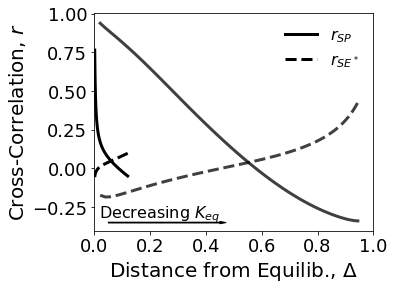

In [128]:
fig,ax = plt.subplots(1,1, figsize=(5,4))

width = 3

#ax.plot(data_gamma_ffa[2][1:-1], data_rcat_ffa[2][1:-1],color='k',alpha=0.6)
#ax.plot(data_gamma_ffa[2][1:-1], data_ract[2][1:-1],color='k',alpha=0.6,linestyle='--')

ax.plot(data_gamma_ffa[10][1:-1], data_rcat_ffa[10][1:-1],color='k',alpha=0.75,linewidth=width)
ax.plot(data_gamma_ffa[10][1:-1], data_ract[10][1:-1],color='k',alpha=0.75,linestyle='--',linewidth=width)

ax.plot(data_gamma_ffa[90][1:-1], data_rcat_ffa[90][1:-1],color='k',alpha=1,label=r'$r_{SP}$',linewidth=width)
ax.plot(data_gamma_ffa[90][1:-1], data_ract[90][1:-1],color='k',alpha=1,linestyle='--',label=r'$r_{SE^*}$',linewidth=width)

ax.set_xlim(1.0,0)
ax.set_xticklabels([1.0, 0.8,0.6,0.4,0.2,0.0])
#ax.set_ylim(-0.1,1.0)

ax.annotate(r'Decreasing $K_{eq}$',xy=(0.25, 0.25), xycoords='figure fraction', rotation = 0, fontsize=16)

ax.arrow(0.95,-0.35,-0.4,0,width=0.005,color='k')

ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon = False, loc = 'best',fontsize=16)

ax.set_xlabel(r'Distance from Equilib., $\Delta$', fontsize=20)
ax.set_ylabel(r'Cross-Correlation, $r$', fontsize=20)

#plt.savefig('res-gamma_act.pdf',bbox_inches='tight')
#plt.savefig('res-gamma_act.png',bbox_inches='tight')

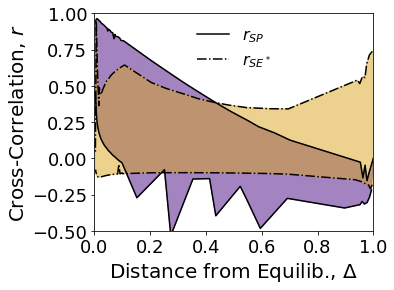

In [129]:
maxrffa,minrffa = get_envelope(data_gamma_ffa[:,1:-1], data_ract[:,1:-1])
maxr,minr = get_envelope(data_gamma_ffa[:,1:-1], data_rcat_ffa[:,1:-1])

fig, ax = plt.subplots(1,1,figsize=(5,4))

x1 = np.array([x[0] for x in maxr])
x2 = np.array([x[0] for x in minr])
y1 = np.array([x[1] for x in maxr])
y2 = np.array([x[1] for x in minr])
ax.plot(x1,y1,color='k')
ax.plot(x2,y2, color = 'k', label = r'$r_{SP}$')

ax.fill(
    np.append(x1, x2[::-1]),
    np.append(y1, y2[::-1]),
    color = 'rebeccapurple', alpha = 0.6)

x1E = np.array([x[0] for x in maxrinh])
x2E = np.array([x[0] for x in minrinh])
y1E = np.array([x[1] for x in maxrinh])
y2E = np.array([x[1] for x in minrinh])
ax.plot(x1E,y1E,color='k',linestyle='-.')
ax.plot(x2E,y2E, color = 'k',linestyle = '-.', label = r'$r_{SE^*}$')

ax.fill(
    np.append(x1E, x2E[::-1]),
    np.append(y1E, y2E[::-1]),
    color = 'goldenrod', alpha = 0.5)

ax.set_xlim(1.0,0)
ax.set_xticklabels([1.0, 0.8,0.6,0.4,0.2,0.0])
ax.set_ylim(-0.5,1.0)
ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon = False, loc = 'best',fontsize=16)

ax.set_xlabel(r'Distance from Equilib., $\Delta$', fontsize=20)
ax.set_ylabel(r'Cross-Correlation, $r$', fontsize=20)

plt.savefig('ffa_envelope.pdf',bbox_inches='tight')
plt.savefig('ffa_envelope.png',bbox_inches='tight')

## C. Analysis of pre-existing -omics data
In this section, a previously-constructed genome-scale network capturing regulatory interactions in E. coli is used alongside thermodynamic data from the Equilibrator database and metabolomic data to understand the relationship between thermodynamic parameters in the metabolic network and the structure of regulatory interactions.

### C.1 Small-molecule regulatory network (SMRN) analysis
A previously-constructed genome-scale SMRN for E. coli is used to identify reactions with regulators among their products and to correlate the presence of regulators to thermodynamic parameters among neighbours. 

Briefly, the SMRN was reconstructed by linking reactions in the iJO1366 model with edges when a reaction produces a substrate of another reaction, or when a reaction produces a regulator of another reaction. For example, if the product of reaction A is a substrate of reaction B, then a directed edge was drawn from node A to node B. To draw regulatory edges, all listed enzyme regulators in the BRENDA database were captured for all reactions in iJO1366. Edges were drawn between reactions which produce a given regulator and reactions for which enzymes are regulated by these regulators.

See C. K. Euler, "On the Regulation of Metabolic Flux by Small Molecules." Order No. 29066635, University of Toronto (Canada), Canada -- Ontario, CA, 2022. for a detailed description of network reconstruction.

This approach is similar to Reznik, et al (2017) (https://doi.org/10.1016/j.celrep.2017.08.066) who published before we could :). See also 

In [181]:
# Read in files

os.chdir('C:\\Users\\euler\\Documents\\PhD\\New Information')
network = pd.read_table('rxn_network_w_modules.txt') # A text file describing directed connections between reactions in iJO1366
reg_network = pd.read_csv('gephi_reg.csv') # A network file containing only the regulatory interactions
                                           # generated by the software Gephi
rxn_network = pd.read_csv('gephi_rxn.csv') # A network file containing only the reaction interactions
                                           # generated by the software Gephi
thermo=pd.read_csv('thermo.csv',index_col='index') # A file containing standard Gibbs free energies for reactions in iJO1366
                                                   # generated via the Equilibrator API
metdata = pd.read_excel('metabolomics.xlsx',sheet_name='metabolomics', index_col=0) # Collated metabolomic data from the sources
rxndata = pd.read_excel('metabolomics.xlsx',sheet_name='rxns', index_col=0)         # references in the manuscript

In [69]:
# Make graph structure from network data

G = nx.DiGraph()
G_rxn = nx.DiGraph()
G_reg = nx.DiGraph()

for i,row in network.iterrows():
    G.add_edge(row['start'],row['end'])
    
    if row['type'] == 'inhibition' or row['type'] == 'activation':
        G_reg.add_edge(row['start'],row['end'],mode=row['type'])
    else:
        G_rxn.add_edge(row['start'],row['end'])

In [70]:
regulators = list(set(network[network['type'] != 'reaction'].start)) # List of reactions with regulators among their products
inhibitors = list(set(network[network['type'] == 'inhibition'].start)) # Split this list into those with inhibitors
activators = [x for x in regulators if x not in inhibitors] # ...and those with activators
all_rxn = list(set(network[network['type'] == 'reaction'].start).union(set(network[network['type'] == 'reaction'].end)))
nonreg = [x for x in all_rxn if x not in regulators] # Find reactions which are non-regulatory

In [71]:
# Get the maximum standard Gibbs free energy of downstream neighbours of reactions of each type

G_max_inh = []
G_min_inh = []

for node in inhibitors:
    
    if node in [x for x in G_rxn.nodes()]:
        neighbors = [x for x in G_rxn.neighbors(node)]
    else:
        continue
    
    temp = []
    for neighbor in neighbors:
        
        if neighbor in thermo.index.values:
            temp.append(thermo.loc[neighbor].delG)     
    if len(temp) == 0:
        continue
    else:
        G_max_inh.append((node,max(temp)))
        G_min_inh.append((node,min(temp)))
        
G_max_reg = []
G_min_reg = []

for node in regulators:
    
    if node in [x for x in G_rxn.nodes()]:
        neighbors = [x for x in G_rxn.neighbors(node)]
    else:
        continue
    
    temp = []
    for neighbor in neighbors:
        
        if neighbor in thermo.index.values:
            temp.append(thermo.loc[neighbor].delG)     
    if len(temp) == 0:
        continue
    else:
        G_max_reg.append((node,max(temp)))
        G_min_reg.append((node,min(temp)))
        
G_max_nonreg = []
G_min_nonreg = []

for node in nonreg:
    
    if node in [x for x in G_rxn.nodes()]:
        neighbors = [x for x in G_rxn.neighbors(node)]
    else:
        continue
    
    temp = []
    for neighbor in neighbors:
        
        if neighbor in thermo.index.values:
            temp.append(thermo.loc[neighbor].delG)     
    if len(temp) == 0:
        continue
    else:
        G_max_nonreg.append((node,max(temp)))
        G_min_nonreg.append((node,min(temp)))
        
G_max_all = []
G_min_all = []

for node in all_rxn:
    
    if node in [x for x in G_rxn.nodes()]:
        neighbors = [x for x in G_rxn.neighbors(node)]
    else:
        continue
    
    temp = []
    for neighbor in neighbors:
        
        if neighbor in thermo.index.values:
            temp.append(thermo.loc[neighbor].delG)     
    if len(temp) == 0:
        continue
    else:
        G_max_all.append((node,max(temp)))
        G_min_all.append((node,min(temp)))

In [72]:
# Perform a statistical comparison between the K_eq values for reactions with regulators among their products ("reg") and 
# those without ("nonreg"). Reasonable limits on standard Gibbs free energies are imposed here.

scipy.stats.ks_2samp([np.exp(-x[1]*1000/(8.314*297)) for x in G_max_reg if x[1] >-100 and x[1] <100],
             [np.exp(-x[1]*1000/(8.314*297)) for x in G_max_nonreg if x[1] >-100 and x[1] <100],alternative = 'greater')

Ks_2sampResult(statistic=0.20188087774294672, pvalue=0.0002462026132282437)

In [73]:
scipy.stats.mannwhitneyu([np.exp(-x[1]*1000/(8.314*297)) for x in G_max_reg if x[1] >-100 and x[1] <100],
             [np.exp(-x[1]*1000/(8.314*297)) for x in G_max_nonreg if x[1] >-100 and x[1] <100],alternative = 'less')

MannwhitneyuResult(statistic=17685.0, pvalue=2.3717756906738363e-05)

Text(0.5, 0, 'Type')

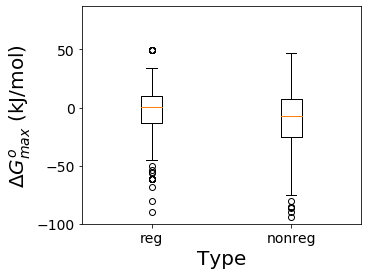

In [77]:
# Visualize max downstream Gibbs free energy distributions. Again, limits are imposed to make visualization tractable

fig,ax = plt.subplots(1,1,figsize=(5,4))

_ = ax.boxplot([[x[1] for x in G_max_reg if x[1] >-100 and x[1] <100],
             [x[1] for x in G_max_nonreg if x[1] >-100 and x[1] <100]])

ax.tick_params(axis='both', which='major', labelsize=14)
plt.xticks([1, 2], ['reg', 'nonreg'],rotation=0)
#ax.axhline(-4,linewidth=0.75,linestyle='--',color='k')

#ax.plot([1, 2], [65, 65], color='k', linestyle='-', linewidth=0.75,alpha=0.6)
#ax.text(1.2,70,r'$p=4.92\cdot 10^{-4}$',fontsize=14)

ax.set_ylim(-100,87)

ax.set_ylabel('$\Delta G^o_{max}$ (kJ/mol)',fontsize=20)
ax.set_xlabel('Type',fontsize=20)

#plt.savefig('delG_comparison.pdf',bbox_inches='tight')
#plt.savefig('delG_comparison.png',bbox_inches='tight')

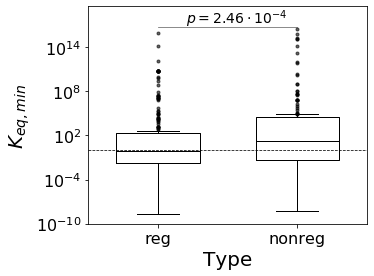

In [75]:
# Visualize the same distributions as K_eq values instead

fig,ax = plt.subplots(1,1,figsize=(5,4))

flierprops = dict(marker='o', markersize=3, markeredgecolor=None, markerfacecolor='k',alpha=0.6)
medianprops = dict(linestyle='-', linewidth=1, color='k')

_ = ax.boxplot([[np.exp(-x[1]*1000/(8.314*297)) for x in G_max_reg if x[1] >-100 and x[1] <100],
             [np.exp(-x[1]*1000/(8.314*297)) for x in G_max_nonreg if x[1] >-100 and x[1] <100]],
              flierprops=flierprops, medianprops=medianprops, widths=0.6)

ax.tick_params(axis='both', which='major', labelsize=14)
plt.xticks([1, 2], ['reg', 'nonreg'],rotation=0)
plt.yscale('log')
ax.axhline(1,linewidth=0.75,linestyle='--',color='k')

ax.plot([1, 2], [10**16.7, 10**16.7], color='k', linestyle='-', linewidth=0.75,alpha=0.6)
ax.text(1.2,10**17.2,r'$p=2.46\cdot 10^{-4}$',fontsize=14)

#ax.plot([1, 2], [65, 65], color='k', linestyle='-', linewidth=0.75,alpha=0.6)
#ax.text(1.2,70,r'$p=1.52\cdot 10^{-6}$',fontsize=14)

ax.set_ylim(10**(-10),10**19.5)

ax.set_ylabel('$K_{eq, min}$',fontsize=20)
ax.set_xlabel('Type',fontsize=20)

ax.tick_params(axis='both', labelsize=16)

#plt.savefig('Keq-type.pdf', bbox_inches='tight')
#plt.savefig('Keq-type.png', bbox_inches='tight')

In [284]:
dfmaxes

,reaction,gmax,classification,organism,kmin
0,TPI,5.426775,reg,E. coli,1.118765e-01
1,GARFT,44.736332,nonreg,E. coli,1.439304e-08
2,DBTS,132.164148,reg,E. coli,6.806115e-24
3,ABTA,4.892187,reg,E. coli,1.388183e-01
4,GSNK,18.567427,reg,E. coli,5.563000e-04
...,...,...,...,...,...
606,THRS,-28.455847,nonreg,H. sapiens,9.728270e+04
607,UGLT,-0.999089,reg,H. sapiens,1.496686e+00
608,IM4ACte,0.000000,nonreg,H. sapiens,1.000000e+00
609,ACDO,-424.090090,reg,H. sapiens,2.182245e+74


In [345]:
max(dfmaxes['kmin'])

1.7580610195758102e+249

In [431]:
# Bin all reactions according to the smallest downstream K_eq value and count the number of regulatory reactions in each bin

n_bins = 24
intervals = np.logspace(-4, 4, n_bins)

freq = []
freqnon = []

for i in range(0,n_bins-1):

    rxns = dfmaxes[(dfmaxes['kmin']>=intervals[i])&(dfmaxes['kmin']<intervals[i+1])]
    reg = dfmaxes[(dfmaxes['kmin']>=intervals[i])&(dfmaxes['kmin']<intervals[i+1])&(dfmaxes['classification']=='reg')]
    nonreg = dfmaxes[(dfmaxes['kmin']>=intervals[i])&(dfmaxes['kmin']<intervals[i+1])&(dfmaxes['classification']=='nonreg')]
    
    if len(rxns)>0:
        freq.append(len(reg)/(len(rxns)))
        freqnon.append(len(nonreg)/(len(rxns)))
    else:
        freq.append(0)
        freqnon.append(0)

Text(0, 0.5, 'Fraction')

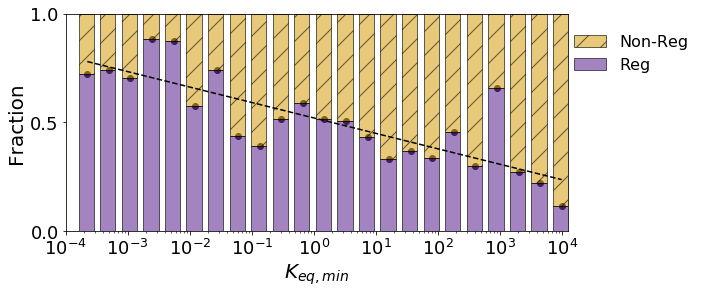

In [432]:
# Visualize the fraction of reactions which are regulatory for each bin

fig,ax = plt.subplots(1,1, figsize=(9,4))

ax.bar(intervals[1:], freqnon, bottom =freq, width=np.diff(intervals), 
       label = 'Non-Reg', color = 'goldenrod' , alpha = 0.6, edgecolor = 'k', hatch="/")
ax.bar(intervals[1:], freq, width=np.diff(intervals), 
       label = 'Reg', color = 'rebeccapurple', alpha = 0.6, edgecolor = 'k')

ax.scatter(intervals[1:], freq,color='k', alpha=1)
regress = scipy.stats.linregress(np.log10(intervals[1:]), freq)
ax.plot(intervals[1:],regress.slope*np.log10(intervals[1:])+regress.intercept,color='k', linestyle='--',alpha=1)

ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.set_xscale('log')
ax.set_ylim(0,1)
ax.set_xlim(10**(-4),10**4.1)

plt.locator_params(axis='y', nbins=3) 

ax.legend(frameon=False,loc=(1,0.7),fontsize=16)

ax.set_xlabel(r'$K_{eq,min}$', fontsize=20)
ax.set_ylabel('Fraction', fontsize=20)

#plt.savefig('fraction-Keq.pdf', bbox_inches='tight')
#plt.savefig('fraction-Keq.png', bbox_inches='tight')

In [430]:
regress #for 114 bins

LinregressResult(slope=-0.06091601077295399, intercept=0.47984983702711487, rvalue=-0.4687457692786785, pvalue=1.6385347838498525e-07, stderr=0.010895749740580036)

In [427]:
regress #for 24 bins

LinregressResult(slope=-0.07095583796360642, intercept=0.5210706453244071, rvalue=-0.8089784438833073, pvalue=2.9692343438647347e-06, stderr=0.011251214945021418)

## C.2 Metabolomics analysis
Previously-collected metabolomic data for up to 14 different carbon sources is analyzed to calculate distance from equilibrium in real metabolic steady states. See the main text for a description of data sources. Collated data is available in linked files.

In [273]:
# Create a data frame to store calculated distance from equilibrium values

affinities = pd.DataFrame(index=rxndata.index, columns = ['Galactose', 'Acetate', 'Mannose', 'Pyruvate', 'Lactate', 
                                                      'Glycerol', 'Sorbitol', 'Fructose', 'Succinate', 'N-acetylglucosamine',
                                                      'Mannitol', 'Gluconate', 'Glucose', 'Glucose-6-Phosphate'])

# Calculate distances
for i in range(0,len(affinities)): # For each reaction
    substrates = rxndata.iloc[i].Substrates.split(', ') # Get substrates
    products = rxndata.iloc[i].Products.split(', ') # Get products
    
    Keq = rxndata.iloc[i].K_eq # Get Keq
    
    for key in affinities.keys(): # Go through each carbon source
        subs = [metdata[key].iloc[np.where(metdata.index == x)][0] for x in substrates]
        prods = [metdata[key].iloc[np.where(metdata.index == x)][0] for x in products]
        
        affinity = -np.log((np.prod(prods)/np.prod(subs))/Keq)
        
        if affinity < 0:
            affinity = -np.log((np.prod(subs)/np.prod(prods))*Keq)
        
        if np.isinf(affinity):
            affinity = NaN
        
        affinities[key].iloc[i] = affinity

GLUDy Galactose
GLUDy Acetate
GLUDy Pyruvate
GLUDy Glycerol
GLUDy Fructose
GLUDy Succinate
GLUDy Gluconate
GLUDy Glucose
FBA Galactose
FBA Acetate
FBA Mannose
FBA Pyruvate
FBA Lactate
FBA Glycerol
FBA Sorbitol
FBA Fructose
FBA Succinate
FBA N-acetylglucosamine
FBA Mannitol
FBA Gluconate
FBA Glucose
FBA Glucose-6-Phosphate
FRUK Galactose
FRUK Acetate
FRUK Pyruvate
FRUK Glycerol
FRUK Fructose
FRUK Succinate
FRUK Gluconate
FRUK Glucose
TKT1 Galactose
TKT1 Fructose
TKT1 Succinate
TKT1 Gluconate
TKT1 Glucose
ACONTa Mannose
ACONTa Lactate
ACONTa Sorbitol
ICDH Galactose
ICDH Acetate
ICDH Pyruvate
ICDH Glycerol
ICDH Fructose
ICDH Succinate
ICDH Gluconate
ICDH Glucose
TPI Galactose
TPI Acetate
TPI Mannose
TPI Pyruvate
TPI Lactate
TPI Glycerol
TPI Sorbitol
TPI Fructose
TPI Succinate
TPI N-acetylglucosamine
TPI Mannitol
TPI Gluconate
TPI Glucose
TPI Glucose-6-Phosphate
TKT2 Sorbitol
TKT2 N-acetylglucosamine
TKT2 Mannitol
TKT2 Gluconate
TKT2 Glucose-6-Phosphate
PGI Acetate
PGI Mannose
PGI Pyruvate

C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:18 RuntimeWarning: invalid value encountered in double_scalars


 Galactose
RPI Acetate
RPI Mannose
RPI Pyruvate
RPI Lactate
RPI Glycerol
RPI Sorbitol
RPI Fructose
RPI Succinate
RPI N-acetylglucosamine
RPI Mannitol
RPI Gluconate
RPI Glucose
RPI Glucose-6-Phosphate
ACONTb Pyruvate
Fumarase Acetate
Fumarase Mannose
Fumarase Glycerol
Fumarase Sorbitol
Fumarase Succinate
Fumarase N-acetylglucosamine
Fumarase Mannitol
Fumarase Glucose
Fumarase Glucose-6-Phosphate
G6PDH2r Galactose
G6PDH2r Acetate
G6PDH2r Pyruvate
G6PDH2r Glycerol
G6PDH2r Fructose
G6PDH2r Gluconate
G6PDH2r Glucose
PFK Glucose-6-Phosphate
SUCDi

C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:18 RuntimeWarning: divide by zero encountered in log
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:18 RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:21 RuntimeWarning: divide by zero encountered in log


 Succinate


In [257]:
affinities

,Galactose,Acetate,Mannose,Pyruvate,Lactate,Glycerol,Sorbitol,Fructose,Succinate,N-acetylglucosamine,Mannitol,Gluconate,Glucose,Glucose-6-Phosphate
Reaction,,,,,,,,,,,,,,
GLUDy,11.129165,12.518045,NaN,11.302131,NaN,12.206767,NaN,11.484069,11.431678,NaN,NaN,12.041648,11.700641,NaN
FBA,8.120355,8.760909,8.085473,9.33339,9.137406,9.609908,8.154998,8.234082,9.03698,7.781767,7.92807,7.94763,5.562681,7.704984
FRUK,5.138548,6.086996,NaN,7.087634,NaN,4.322722,NaN,7.397062,6.128461,NaN,NaN,5.684358,4.725582,NaN
TKT1,2.609917,0.223401,NaN,0.045574,NaN,2.505042,NaN,0.158507,0.093151,NaN,NaN,2.048252,1.68689,NaN
ACONTa,0.091405,1.067598,0.22657,1.46228,0.24518,0.841751,0.191556,0.272362,0.206813,0.230288,0.007196,0.15116,1.167106,0.113598
ICDH,6.404946,7.572492,NaN,5.685638,NaN,9.607714,NaN,7.559388,7.915736,NaN,NaN,8.051933,8.772961,NaN
TPI,1.594039,1.754248,1.1737,1.88369,2.007282,2.722943,0.957255,0.688817,1.473059,1.168681,1.042907,0.493251,0.671696,0.298459
TKT2,1.217179,2.345857,0.12686,4.2275,1.371979,4.652178,0.143808,1.081604,2.448918,1.079267,0.751,0.120736,0.128278,2.248275
TALA,3.398196,2.174588,NaN,2.558734,NaN,4.931351,NaN,1.678017,2.225755,NaN,NaN,3.204159,2.743941,NaN


In [258]:
reg_list = ['GLUDy', 'FBA', 'TKT1','ACONTa','ICDH','TKT2','TALA','RPI','RPE','Fumarase','FBP','PFK','SUCDi','AKG2SUCC',
           'PYK','ASPSB'] # Manually-curated list of reactions with regulators among their products in either direction

# Separate out distance from equilibrium for both regulatory and non-regulatory reactions

reg_temp = [affinities.loc[x].values for x in reg_list]
reg_affinities = [item for sublist in reg_temp for item in sublist if np.isnan(item) == False] 

nonreg_temp = [affinities.loc[x].values for x in affinities.index if x not in reg_list]
nonreg_affinities = [item for sublist in nonreg_temp for item in sublist if np.isnan(item) == False]

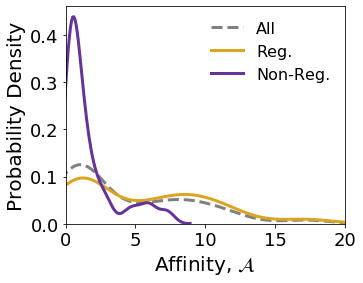

In [261]:
# Visualize distributions of real distances from equilibrium for all reactions and regulatory and non-regulatory reactions

fig,ax = plt.subplots(1,1,figsize=(5,4))

ax.tick_params(axis='both', which='major', labelsize=14)

ax.set_xlim(0,20)

sns.distplot(affinities,hist=False,ax=ax,label='All',color='grey',kde_kws=dict(linewidth=3,linestyle='--'))
sns.distplot(reg_affinities,hist=False,ax=ax,label='Reg.',color='goldenrod',kde_kws=dict(linewidth=3))
sns.distplot(nonreg_affinities,hist=False,ax=ax,label='Non-Reg.',color='rebeccapurple',kde_kws=dict(linewidth=3))

ax.tick_params(axis='both', labelsize=18)

ax.legend(frameon = False, loc = 'best',fontsize=16)

ax.set_xlabel(r'Affinity, $\mathcal{A}$', fontsize=20)
ax.set_ylabel(r'Probability Density', fontsize=20)

plt.savefig('realaffinities.pdf',bbox_inches='tight')
plt.savefig('realaffinities.png',bbox_inches='tight')

In [262]:
scipy.stats.mannwhitneyu(reg_affinities, nonreg_affinities)

MannwhitneyuResult(statistic=2648.0, pvalue=3.515427466926128e-08)

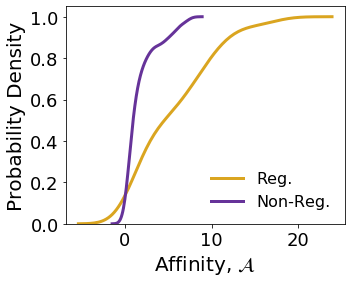

In [263]:
fig,ax = plt.subplots(1,1,figsize=(5,4))

ax.tick_params(axis='both', which='major', labelsize=14)

#ax.set_xlim(0,1)

ax.set_ylabel('Probability Density',fontsize=20)
ax.set_xlabel(r'Affinity, $\mathcal{A}$',fontsize=20)

ax.tick_params(axis='both', labelsize=18)

#sns.kdeplot(gammas,cumulative=True,ax=ax,label='All Reactions',color='grey')
sns.kdeplot(reg_affinities,cumulative=True,ax=ax,label='Reg.',color='goldenrod',linewidth=3)
sns.kdeplot(nonreg_affinities,cumulative=True,ax=ax,label='Non-Reg.',color='rebeccapurple',linewidth=3)

ax.legend(frameon=False,loc='best',fontsize=16)

plt.savefig('realgammascum.pdf',bbox_inches='tight')
plt.savefig('realgammascum.png',bbox_inches='tight')

In [254]:
# Leave-k-out resampling to estimate upper bound on p-value for different in gamma values for regulatory and non-regulatory
# reactions.

p_vals = []
n = 10**6

for i in range(0,n):
    temp_reg = random.sample(reg_affinities,len(reg_affinities)-21)
    temp_nonreg = random.sample(nonreg_affinities,len(nonreg_affinities)-21)
    
    stat,p = scipy.stats.mannwhitneyu(temp_reg, temp_nonreg)

    p_vals.append(p)
    
(n - len([x for x in p_vals if x<0.05]))/n

0.0

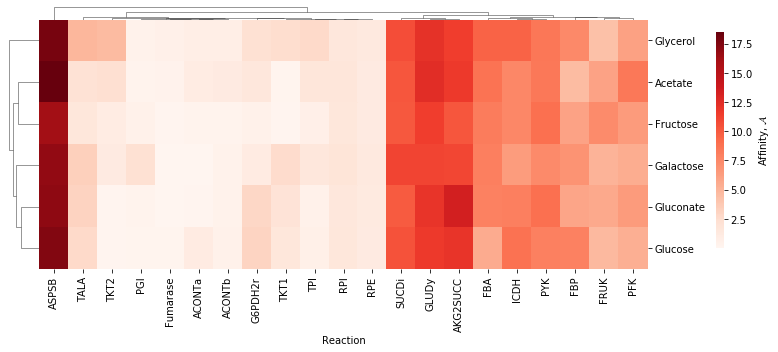

In [271]:
# Visualize a heat map of distance from equilibrium for reactions with complete data across carbon sources

affinities_nonans = affinities.dropna(axis=1,inplace=False)
cm = sns.clustermap(affinities_nonans.astype(float).T, cmap = "Reds",annot_kws={"size": 20},figsize=(10,5),
                    dendrogram_ratio=0.05,cbar_pos=(1, 0.3, 0.01, 0.6),
                    cbar_kws={'label': r'Affinity, $\mathcal{A}$'})

plt.savefig('heatmap.pdf',bbox_inches='tight')
plt.savefig('heatmap.png',bbox_inches='tight')